# <b>TrackML/HotelRank</b>: Elevating Revenue Performance Through Machine Learning and Deep Learning Techniques.

Revenue management is a very important to make profits in the hotel industry, three main factors play an important role to get it right:  
    <ol>
    <li>Hotel room demand over time (demand forecast).</li>
    <li>Prediction of the future booking and inspection of cancellations</li>
    <li>Online hotel reputation.</li>
    </ol>
In this project we take in account each one thru a linear combination of different scores that represent each item. Our customer, Blastnesss.com has provided the data. For customer requirement we give factors 1.5 to Hotel room demand, 0.8 to prediction of booking cancellations, 0.5 to Online reputation, so for business requirement we have:

$$ HotelRank = 1.5 * DemandScore + 0.8 * CancellationScore + 0.5 * ReviewScore + 0 * OtherEventsScore $$


Just to clarify:
- DemandScore : Model demand forecast.
- CancellationScore: Model booking cancellations.
- ReviewScore: Model online reputation.
- OtherEventsScore: Model external factors.

This work has been uploaded and developed through Google Colab due to the intensive computational resources required.



# <b>DemandScore</b>: Demand Forecast Study.

The objective to section to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- We have to clean the data provided and see patterns.
- Detect outliers in the demand score.
- Compare SARIMAX and prophet neural network to see which fits better for the demandscore.
- Create the demand score for each hotel using booking forecast in next temporal year frame.
- We leave to future work any crossdata about the demand related to weather and external events.

As first step for series forecasting we need to analyze

In [1]:
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels pycaret datasets prophet

## Data Cleaning

As first action we load the csv provided by [Blastness](https://www.blastness.com) and we create a dataset with columns names in English

We need to check if we're or not in Colab, if we're not we disable traning for review score and use a prerained model.

In [2]:
# check if i am in colab.
import os
if 'COLAB_GPU' in os.environ:
  from google.colab import drive
  os.environ['CAPSTONE_COLAB']='1'
  drive.mount('/content/drive', force_remount=True)
else:
  os.environ['CAPSTONE_COLAB']='0'

is_colab = int(os.environ.get('CAPSTONE_COLAB'))
if is_colab == 1:
  print('Good Luck working with Google Colab!')
else:
  print('Disabling BERT training!')

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Mounted at /content/drive
Good Luck working with Google Colab!


In [3]:

import glob
import pandas as pd
pd.options.mode.copy_on_write = True
if is_colab:
  filelist = glob.glob('/content/drive/MyDrive/hoteldataset/*.csv')
else:
  filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


<ipython-input-3-916f4fa0ec2c>:22: DtypeWarning: Columns (23,53,62,68,70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
<ipython-input-3-916f4fa0ec2c>:22: DtypeWarning: Columns (23,52,55,58,59,60,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
<ipython-input-3-916f4fa0ec2c>:22: DtypeWarning: Columns (23,49,55,59,81,87,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
<ipython-input-3-916f4fa0ec2c>:22: DtypeWarning: Columns (23,52,53,55,58,59,60,62,68,70,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


Code      Status BookingChannel     Arrival   Departure  Nights  \
0  GN200KZEYQI1  Confermata           Sito  30/09/2006  01/10/2006       1   
1  YR200KTNTGX2  Cancellata           Sito  12/09/2006  13/09/2006       0   
2  CD200SIBGGQ5  Confermata           Sito  15/10/2006  17/10/2006       2   
3  KL200QSBLYE4  Confermata           Sito  15/10/2006  17/10/2006       2   
4  SW200VWGTGG3  Confermata           Sito  15/10/2006  17/10/2006       2   

    Total PurchaseDate BookingDevice         LastModified HotelId  
0  451,00   01/09/2006       Website  01/09/2006 14:11:10     010  
1    0,00   03/09/2006       Website  03/09/2006 20:33:41     010  
2  583,00   04/09/2006       Website  04/09/2006 18:35:23     010  
3  583,00   04/09/2006       Website  04/09/2006 18:35:23     010  
4  583,00   04/09/2006       Website  04/09/2006 18:35:23     010

Now we merge all hotels in a single dataframe and save to disk. We note that we need to divide cancelled and confirmed booking. Later since we want do forecast on the confirmed.
- Also we need to categorize the origin
- remove the booking device.

First we merge.

In [4]:
# Merge DataFrames
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0       1400576136/1204413850  Cancellata    Booking.com  22/07/2017   
1       1240874198/1204820657  Cancellata    Booking.com  15/07/2017   
2       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
3       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
4       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
...                       ...         ...            ...         ...   
151852           XA200DO52912  Confermata           Sito  25/07/2023   
151853           EZ200NJ52913  Confermata           Sito  25/07/2023   
151854           GG200OT52914  Confermata           Sito  26/05/2023   
151855           MG200OY52915  Confermata           Sito  28/06/2023   
151856           QB200WI52916  Confermata           Sito  28/06/2023   

         Departure  Nights    Total PurchaseDate BookingDevice  \
0       29/07/2017       0     0,00   01/01/2017   

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the booking from 2019 to 2023. We might restrict further the dataset if it is needed.

In [5]:
merged_df.head()

Code      Status BookingChannel     Arrival   Departure  \
0  1400576136/1204413850  Cancellata    Booking.com  22/07/2017  29/07/2017   
1  1240874198/1204820657  Cancellata    Booking.com  15/07/2017  02/08/2017   
2  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
3  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
4  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   

   Nights Total PurchaseDate BookingDevice         LastModified HotelId  
0       0  0,00   01/01/2017           NaN  01/01/2017 15:27:39     001  
1       0  0,00   01/01/2017           NaN  01/01/2017 23:13:49     001  
2       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001  
3       0  0,00   01/01/2017           NaN  10/01/2017 22:10:56     001  
4       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001

In [6]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'],dayfirst=True)
# Sorting by 'Arrival' column in descending order
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
# Filtering for HotelId '001'
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

Code      Status BookingChannel    Arrival  \
149489  2153545395/3831705879  Cancellata    Booking.com 2023-11-24   
148295           TX200XB49353  Confermata           Sito 2023-11-08   
151823             1420138502  Confermata        Expedia 2023-11-05   
151753           QR200YV52813  Cancellata           Sito 2023-10-08   
151756           ET200TF52816  Confermata           Sito 2023-10-08   

         Departure  Nights    Total PurchaseDate BookingDevice  \
149489  26/11/2023       0     0,00   28/08/2022           NaN   
148295  11/11/2023       3  1047,00   16/06/2022       Website   
151823  08/11/2023       3  1454,40   05/12/2022           NaN   
151753  12/10/2023       0     0,00   30/11/2022        Mobile   
151756  12/10/2023       4  2455,20   30/11/2022        Mobile   

               LastModified HotelId  
149489  28/08/2022 23:53:03     010  
148295  16/06/2022 19:42:39     010  
151823  05/12/2022 13:59:00     010  
151753  30/11/2022 19:04:33     010  
151756  30/11/2022 19:18:56     010

Now I convert datates to timestamps and check for null values.

In [7]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


Code      Status BookingChannel    Arrival  Departure  \
6543            B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
6620            A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
6621            H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
6556            R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
67683  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
6543        0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     002   
6620        0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     002   
6621        3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     002   
6556        0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     002   
67683       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
6543   1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
6620   1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
6621   1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
6556   1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
67683  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp  
6543   1686787200000000000  
6620   1687392000000000000  
6621   1687392000000000000  
6556   1686960000000000000  
67683  1678838400000000000

We want to add the city to he dataset the client has provided the following mapping:
```
hotel_to_city = {
    '001': "Rome, Italy",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```
So we can have a complete a dataset to correlate in future with events, weather and so on.

In [8]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the season because we know from the domain the booking changes of season and when the booking device is not known.

In [9]:
# we clean unknown
sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



<ipython-input-9-7d6bfddc963d>:2: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)


Code      Status BookingChannel    Arrival  Departure  \
6543            B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
6620            A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
6621            H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
6556            R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
67683  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
6543        0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     002   
6620        0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     002   
6621        3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     002   
6556        0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     002   
67683       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
6543   1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
6620   1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
6621   1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
6556   1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
67683  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp    City  Season  
6543   1686787200000000000  Naples  Spring  
6620   1687392000000000000  Naples  Spring  
6621   1687392000000000000  Naples  Spring  
6556   1686960000000000000  Naples  Spring  
67683  1678838400000000000   Olbia  Spring

Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file.

In [10]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


Code      Status BookingChannel    Arrival  Departure  \
67683  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   
67681  2694489967/4142285639  Cancellata    Booking.com 2024-03-30 2024-04-06   
67682  2262350217/4142372765  Cancellata    Booking.com 2024-03-30 2024-04-06   
68120  3250233143/4271797361  Cancellata    Booking.com 2024-03-29 2024-04-01   
68119  3250233143/4271797361  Confermata    Booking.com 2024-03-28 2024-03-31   

       Nights  Total PurchaseDate BookingDevice        LastModified HotelId  \
67683       0    0.0   2023-03-15           NaN 2023-03-15 21:44:16     008   
67681       0    0.0   2023-03-15           NaN 2023-03-15 20:31:35     008   
67682       0    0.0   2023-03-15           NaN 2023-03-15 21:22:16     008   
68120       0    0.0   2023-05-28           NaN 2023-05-28 13:55:50     008   
68119       3  661.5   2023-05-28           NaN 2023-05-28 13:55:50     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
67683  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   
67681  1711756800000000000  1712361600000000000    2023-03-15 20:31:35   
67682  1711756800000000000  1712361600000000000    2023-03-15 21:22:16   
68120  1711670400000000000  1711929600000000000    2023-05-28 13:55:50   
68119  1711584000000000000  1711843200000000000    2023-05-28 13:55:50   

        Purchase_Timestamp   City  Season  
67683  1678838400000000000  Olbia  Spring  
67681  1678838400000000000  Olbia  Spring  
67682  1678838400000000000  Olbia  Spring  
68120  1685232000000000000  Olbia  Spring  
68119  1685232000000000000  Olbia  Spring

Ok. We've seen that the booking channel can be a valid string or Unknown. The other thing that we want is to the hotel booking for a fixed period from 2024 to 2022. After this we can

In [11]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df.head()


Code      Status BookingChannel    Arrival  Departure  \
6543            B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
6620            A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
6621            H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
6556            R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
67683  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
6543        0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     002   
6620        0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     002   
6621        3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     002   
6556        0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     002   
67683       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
6543   1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
6620   1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
6621   1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
6556   1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
67683  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp    City  Season  
6543   1686787200000000000  Naples  Spring  
6620   1687392000000000000  Naples  Spring  
6621   1687392000000000000  Naples  Spring  
6556   1686960000000000000  Naples  Spring  
67683  1678838400000000000   Olbia  Spring

Now I want to restrict the timing interval between 2020 and 2023 because later we'll do series forecast and we wnat to reduce the risk of [data snooping] (https://datascience.stanford.edu/news/data-snooping).


In [12]:
start_date = '2020-01-01'
end_date = '2023-12-31'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)]
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    rows_with_nan = hb_dataset[hb_dataset.isna().any(axis=1)]
    print("Rows with NaN values:")
    rows_with_nan.head()
else:
    print('The dataset is ready some descriptivre statistics')

Does the DataFrame contain any NaN values? True
Rows with NaN values:


In [13]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


In [14]:
hb_dataset.head(10)

Code      Status BookingChannel    Arrival  Departure  \
68186  2493115910/4283897556  Confermata    Booking.com 2023-12-28 2024-01-04   
68289  2745673363/4308678121  Confermata    Booking.com 2023-12-27 2024-01-03   
68239  3854867487/4296773334  Confermata    Booking.com 2023-12-26 2024-01-02   
68400  3958853713/4337114239  Confermata    Booking.com 2023-12-26 2024-01-02   
67400  2165812668/4071186490  Cancellata    Booking.com 2023-12-23 2023-12-30   
68116  2359160563/4271754038  Confermata    Booking.com 2023-12-23 2023-12-31   
68118  2359160563/4271754047  Confermata    Booking.com 2023-12-23 2023-12-31   
68117  2359160563/4271754066  Confermata    Booking.com 2023-12-23 2023-12-31   
67401  2165812668/4071186490  Confermata    Booking.com 2023-12-23 2023-12-30   
68094  3626349779/4266644156  Confermata    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate BookingDevice        LastModified HotelId  \
68186       7  4637.25   2023-06-04           NaN 2023-06-04 09:27:30     008   
68289       7  3892.05   2023-06-17           NaN 2023-06-17 18:09:53     008   
68239       7  2620.35   2023-06-11           NaN 2023-06-11 10:53:57     008   
68400       7  2766.15   2023-07-02           NaN 2023-07-02 16:35:28     008   
67400       0     0.00   2023-02-03           NaN 2023-05-10 23:21:21     008   
68116       8  2997.00   2023-05-28           NaN 2023-05-28 13:16:41     008   
68118       8  3126.60   2023-05-28           NaN 2023-05-28 13:16:41     008   
68117       8  3240.00   2023-05-28           NaN 2023-05-28 13:16:41     008   
67401       7  3154.50   2023-02-03           NaN 2023-05-10 23:21:21     008   
68094       7  3001.50   2023-05-25           NaN 2023-05-25 10:41:31     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
68186  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
68289  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
68239  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
68400  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
67400  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
68116  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
68118  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
68117  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
67401  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
68094  1703203200000000000  1703808000000000000    2023-05-25 10:41:31   

        Purchase_Timestamp   City  Season  
68186  1685836800000000000  Olbia  Winter  
68289  1686960000000000000  Olbia  Winter  
68239  1686441600000000000  Olbia  Winter  
68400  1688256000000000000  Olbia  Winter  
67400  1675382400000000000  Olbia  Winter  
68116  1685232000000000000  Olbia  Winter  
68118  1685232000000000000  Olbia  Winter  
68117  1685232000000000000  Olbia  Winter  
67401  1675382400000000000  Olbia  Winter  
68094  1684972800000000000  Olbia  Winter

We begin by analyzing and understanding the categorical variables "Status" and "Booking Devices" and applying an Ordinal Encoder for their transformation. For the "Status" category, we anticipate the following values: Confermata (Confirmed), Cancellata (Cancelled), and Modificata (Modified). This encoding will later be instrumental in calculating the cancellation score.

In [15]:
hb_dataset['Status'].unique()

array(['Confermata', 'Cancellata', 'Modificata'], dtype=object)

In [16]:
hb_dataset['BookingDevice'].dropna()
hb_dataset['BookingDevice'].unique()

array([nan, 'Mobile', 'Website', 'Tablet'], dtype=object)

In [17]:
from sklearn.preprocessing import OrdinalEncoder
status_categories = hb_dataset[['Status']]
device_categories = hb_dataset[['BookingDevice']]
ordinal_encoder = OrdinalEncoder()
hb_dataset_booking_cat = ordinal_encoder.fit_transform(status_categories).copy()
hb_dataset_booking_device = ordinal_encoder.fit_transform(device_categories).copy()
hb_dataset['Status'] = hb_dataset_booking_cat
hb_dataset['BookingDevice'] = hb_dataset_booking_device
hb_dataset.head(10)

Code  Status BookingChannel    Arrival  Departure  \
68186  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
68289  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
68239  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
68400  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
67400  2165812668/4071186490     0.0    Booking.com 2023-12-23 2023-12-30   
68116  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   
68118  2359160563/4271754047     1.0    Booking.com 2023-12-23 2023-12-31   
68117  2359160563/4271754066     1.0    Booking.com 2023-12-23 2023-12-31   
67401  2165812668/4071186490     1.0    Booking.com 2023-12-23 2023-12-30   
68094  3626349779/4266644156     1.0    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate  BookingDevice        LastModified  \
68186       7  4637.25   2023-06-04            NaN 2023-06-04 09:27:30   
68289       7  3892.05   2023-06-17            NaN 2023-06-17 18:09:53   
68239       7  2620.35   2023-06-11            NaN 2023-06-11 10:53:57   
68400       7  2766.15   2023-07-02            NaN 2023-07-02 16:35:28   
67400       0     0.00   2023-02-03            NaN 2023-05-10 23:21:21   
68116       8  2997.00   2023-05-28            NaN 2023-05-28 13:16:41   
68118       8  3126.60   2023-05-28            NaN 2023-05-28 13:16:41   
68117       8  3240.00   2023-05-28            NaN 2023-05-28 13:16:41   
67401       7  3154.50   2023-02-03            NaN 2023-05-10 23:21:21   
68094       7  3001.50   2023-05-25            NaN 2023-05-25 10:41:31   

      HotelId    Arrival_Timestamp  Departure_Timestamp  \
68186     008  1703721600000000000  1704326400000000000   
68289     008  1703635200000000000  1704240000000000000   
68239     008  1703548800000000000  1704153600000000000   
68400     008  1703548800000000000  1704153600000000000   
67400     008  1703289600000000000  1703894400000000000   
68116     008  1703289600000000000  1703980800000000000   
68118     008  1703289600000000000  1703980800000000000   
68117     008  1703289600000000000  1703980800000000000   
67401     008  1703289600000000000  1703894400000000000   
68094     008  1703203200000000000  1703808000000000000   

      LastModified_Timestamp   Purchase_Timestamp   City  Season  
68186    2023-06-04 09:27:30  1685836800000000000  Olbia  Winter  
68289    2023-06-17 18:09:53  1686960000000000000  Olbia  Winter  
68239    2023-06-11 10:53:57  1686441600000000000  Olbia  Winter  
68400    2023-07-02 16:35:28  1688256000000000000  Olbia  Winter  
67400    2023-05-10 23:21:21  1675382400000000000  Olbia  Winter  
68116    2023-05-28 13:16:41  1685232000000000000  Olbia  Winter  
68118    2023-05-28 13:16:41  1685232000000000000  Olbia  Winter  
68117    2023-05-28 13:16:41  1685232000000000000  Olbia  Winter  
67401    2023-05-10 23:21:21  1675382400000000000  Olbia  Winter  
68094    2023-05-25 10:41:31  1684972800000000000  Olbia  Winter

## Descriptive statistics

In this section we need a basic descriptive statistics.


In [18]:
descriptive_stats = hb_dataset.describe()
# we will use later for compute the score
canc_score_compute = hb_dataset.copy()
print("\nDescriptive Statistics for numeric columns in the filtered DataFrame:")
descriptive_stats



Descriptive Statistics for numeric columns in the filtered DataFrame:


Status                        Arrival  \
count  39340.000000                          39340   
mean       0.589553  2022-01-15 05:26:04.087442688   
min        0.000000            2020-01-01 00:00:00   
25%        0.000000            2021-06-03 00:00:00   
50%        1.000000            2022-04-29 00:00:00   
75%        1.000000            2022-09-25 00:00:00   
max        2.000000            2023-12-28 00:00:00   
std        0.525452                            NaN   

                           Departure        Nights         Total  \
count                          39340  39340.000000  39340.000000   
mean   2022-01-18 05:00:13.543467264      1.516548    396.177232   
min              2020-01-02 00:00:00      0.000000      0.000000   
25%              2021-06-06 00:00:00      0.000000      0.000000   
50%              2022-05-01 00:00:00      1.000000    144.900000   
75%              2022-09-28 00:00:00      2.000000    531.000000   
max              2024-01-04 00:00:00     30.000000  20124.000000   
std                              NaN      1.967660    667.932308   

                        PurchaseDate  BookingDevice  \
count                          39340    6280.000000   
mean   2021-11-07 05:08:32.089476608       1.513376   
min              2019-03-22 00:00:00       0.000000   
25%              2021-02-08 00:00:00       1.000000   
50%              2022-02-18 00:00:00       2.000000   
75%              2022-08-23 06:00:00       2.000000   
max              2023-07-02 00:00:00       2.000000   
std                              NaN       0.847213   

                        LastModified  Arrival_Timestamp  Departure_Timestamp  \
count                          39340       3.934000e+04         3.934000e+04   
mean   2021-11-12 00:25:43.714463744       1.642224e+18         1.642482e+18   
min              2019-03-22 12:49:30       1.577837e+18         1.577923e+18   
25%    2021-02-16 18:33:42.750000128       1.622678e+18         1.622938e+18   
50%              2022-02-24 18:27:41       1.651190e+18         1.651363e+18   
75%       2022-08-25 15:44:03.500000       1.664064e+18         1.664323e+18   
max              2023-07-02 22:29:40       1.703722e+18         1.704326e+18   
std                              NaN       3.238879e+16         3.238956e+16   

              LastModified_Timestamp  Purchase_Timestamp  
count                          39340        3.934000e+04  
mean   2021-11-12 00:25:43.714463744        1.636262e+18  
min              2019-03-22 12:49:30        1.553213e+18  
25%    2021-02-16 18:33:42.750000128        1.612742e+18  
50%              2022-02-24 18:27:41        1.645142e+18  
75%       2022-08-25 15:44:03.500000        1.661234e+18  
max              2023-07-02 22:29:40        1.688256e+18  
std                              NaN        3.338754e+16

In [19]:
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
descriptive_stats_all


Descriptive Statistics for all columns in the filtered DataFrame:


Code        Status BookingChannel  \
count             39340  39340.000000          39340   
unique            36740           NaN             57   
top     M41DPG/554481/1           NaN    Booking.com   
freq                 13           NaN          23383   
mean                NaN      0.589553            NaN   
min                 NaN      0.000000            NaN   
25%                 NaN      0.000000            NaN   
50%                 NaN      1.000000            NaN   
75%                 NaN      1.000000            NaN   
max                 NaN      2.000000            NaN   
std                 NaN      0.525452            NaN   

                              Arrival                      Departure  \
count                           39340                          39340   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean    2022-01-15 05:26:04.087442688  2022-01-18 05:00:13.543467264   
min               2020-01-01 00:00:00            2020-01-02 00:00:00   
25%               2021-06-03 00:00:00            2021-06-06 00:00:00   
50%               2022-04-29 00:00:00            2022-05-01 00:00:00   
75%               2022-09-25 00:00:00            2022-09-28 00:00:00   
max               2023-12-28 00:00:00            2024-01-04 00:00:00   
std                               NaN                            NaN   

              Nights         Total                   PurchaseDate  \
count   39340.000000  39340.000000                          39340   
unique           NaN           NaN                            NaN   
top              NaN           NaN                            NaN   
freq             NaN           NaN                            NaN   
mean        1.516548    396.177232  2021-11-07 05:08:32.089476608   
min         0.000000      0.000000            2019-03-22 00:00:00   
25%         0.000000      0.000000            2021-02-08 00:00:00   
50%         1.000000    144.900000            2022-02-18 00:00:00   
75%         2.000000    531.000000            2022-08-23 06:00:00   
max        30.000000  20124.000000            2023-07-02 00:00:00   
std         1.967660    667.932308                            NaN   

        BookingDevice                   LastModified HotelId  \
count     6280.000000                          39340   39340   
unique            NaN                            NaN      10   
top               NaN                            NaN     010   
freq              NaN                            NaN   10720   
mean         1.513376  2021-11-12 00:25:43.714463744     NaN   
min          0.000000            2019-03-22 12:49:30     NaN   
25%          1.000000  2021-02-16 18:33:42.750000128     NaN   
50%          2.000000            2022-02-24 18:27:41     NaN   
75%          2.000000     2022-08-25 15:44:03.500000     NaN   
max          2.000000            2023-07-02 22:29:40     NaN   
std          0.847213                            NaN     NaN   

        Arrival_Timestamp  Departure_Timestamp         LastModified_Timestamp  \
count        3.934000e+04         3.934000e+04                          39340   
unique                NaN                  NaN                            NaN   
top                   NaN                  NaN                            NaN   
freq                  NaN                  NaN                            NaN   
mean         1.642224e+18         1.642482e+18  2021-11-12 00:25:43.714463744   
min          1.577837e+18         1.577923e+18            2019-03-22 12:49:30   
25%          1.622678e+18         1.622938e+18  2021-02-16 18:33:42.750000128   
50%          1.651190e+18         1.651363e+18            2022-02-24 18:27:41   
75%          1.664064e+18         1.664323e+18     2022-08-25 15:44:03.500000   
max          1.703722e+18         1.704326e+18            2023-07-02 22:2

In [20]:
hb_dataset.isnull().sum()

Code                          0
Status                        0
BookingChannel                0
Arrival                       0
Departure                     0
Nights                        0
Total                         0
PurchaseDate                  0
BookingDevice             33060
LastModified                  0
HotelId                       0
Arrival_Timestamp             0
Departure_Timestamp           0
LastModified_Timestamp        0
Purchase_Timestamp            0
City                          0
Season                        0
dtype: int64

We know that:
- We've 39345 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.
- We have to drop BookingDevice.

In [21]:
hb_dataset.drop(columns=['BookingDevice'], inplace=True)

That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked?

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

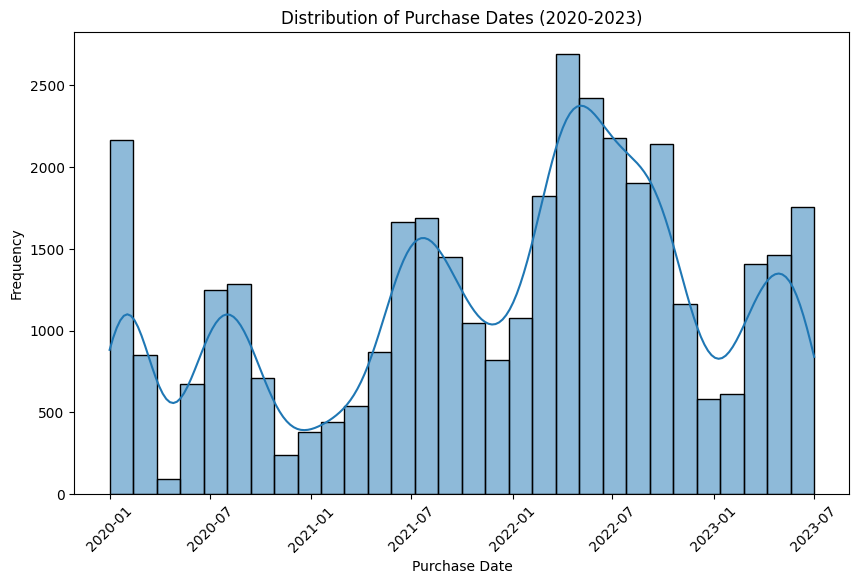

In [23]:
start_date = '2020-01-01'
end_date = '2023-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

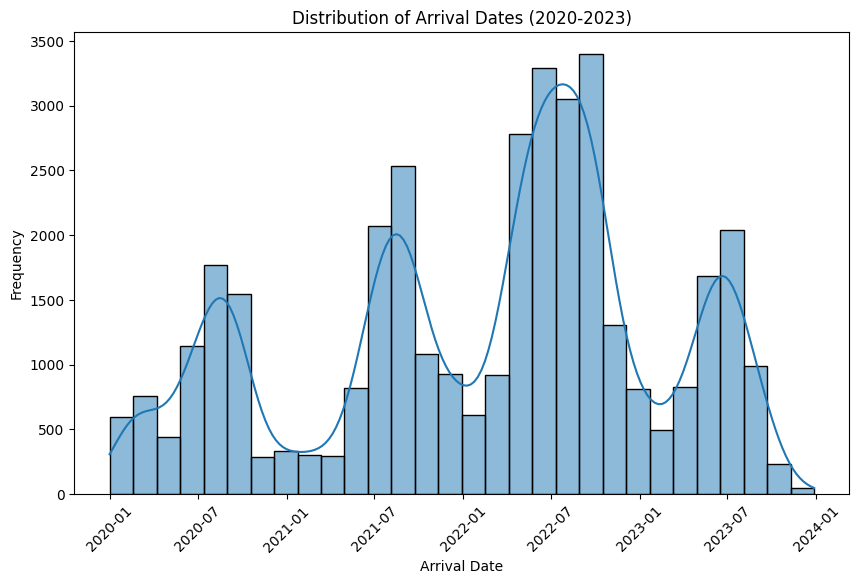

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book. Our goal is to see if there is seasonality or it is [cyclic pattern](https://robjhyndman.com/hyndsight/cyclicts). Each year show us the same behaviour in terms of booking.

  Distribution  KS Statistic  P-Value
0         norm      0.106293      0.0
1        expon      0.277902      0.0
2        gamma      0.113996      0.0
3      lognorm      0.106296      0.0
4         beta      0.137298      0.0


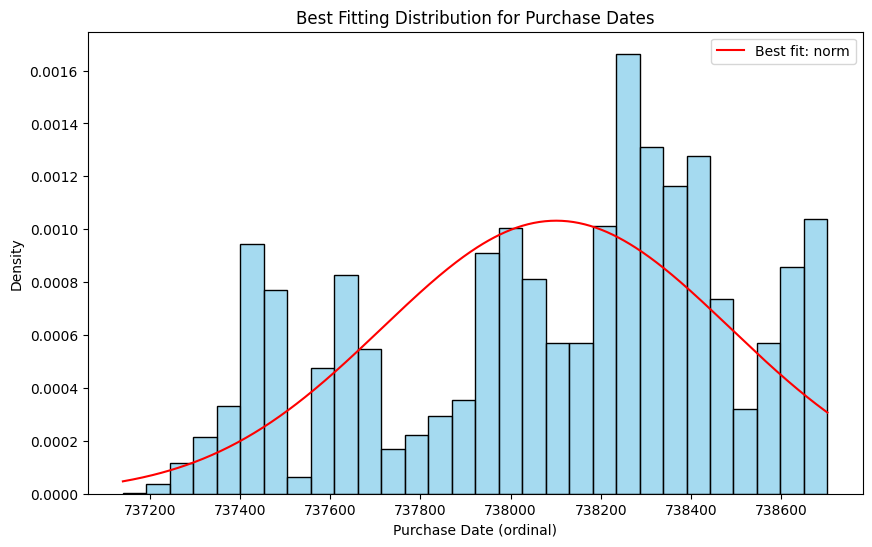

In [25]:

purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

x = np.linspace(min(purchase_dates), max(purchase_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


Some other studies have been found that a normal distribution model quite well also arrival: https://www.sciencedirect.com/science/article/abs/pii/S0261517717302431


  Distribution  KS Statistic  P-Value
0         norm      0.118242      0.0
1        expon      0.253936      0.0
2        gamma      0.126179      0.0
3      lognorm      0.118242      0.0
4         beta      0.109427      0.0


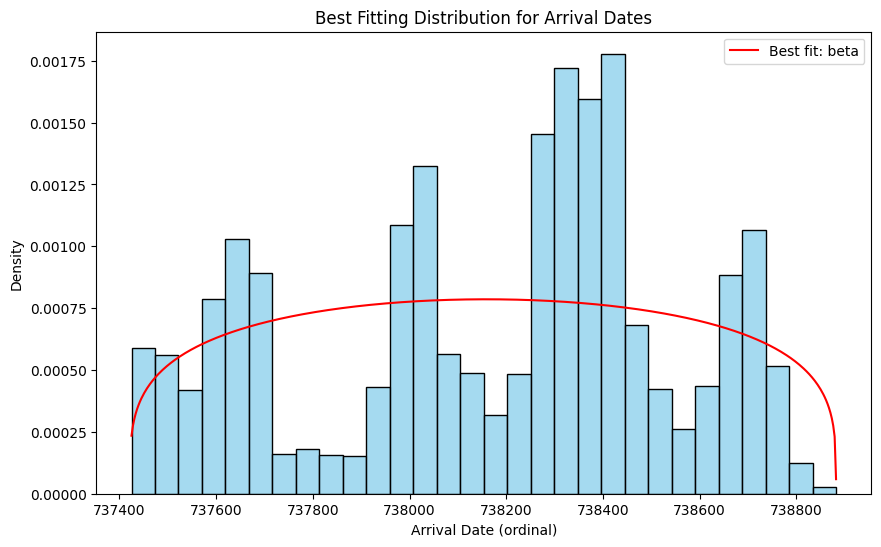

In [26]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(arrival_dates), max(arrival_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

## Which between our customers had most revenue?

In [27]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


HotelId                 City       Total
9     010                 Rome  6398486.80
7     008                Olbia  2418291.75
1     002               Naples  1808414.24
8     009  Chamonix-Mont-Blanc  1606252.54
6     007               Latina  1545058.55

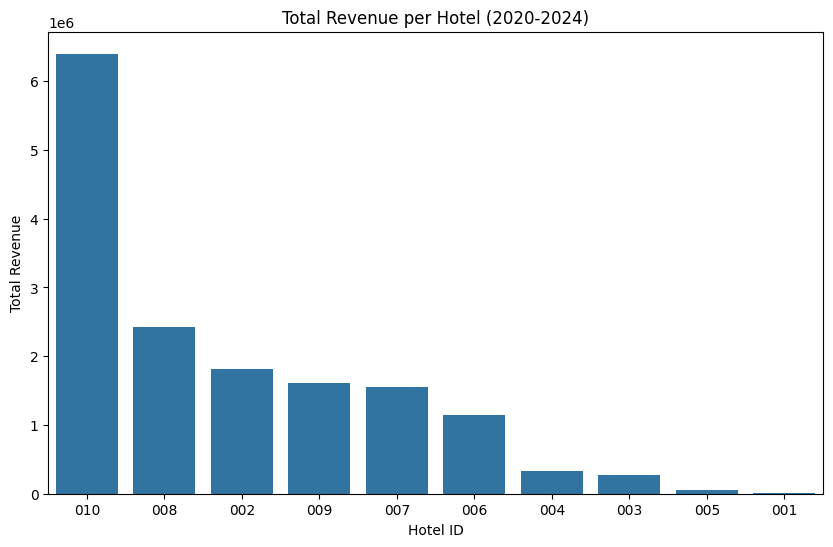

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2024)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features. We will take, our best customer as sample to develop the metodology that can be applied to the others. So Hotel008 is the most interesting client, we took as example to study our demand and generalize the algorithm to other customers.

In [29]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                       Status    Nights     Total  Arrival_Timestamp  \
Status               1.000000  0.645211  0.513571           0.178381   
Nights               0.645211  1.000000  0.794623           0.156894   
Total                0.513571  0.794623  1.000000           0.198652   
Arrival_Timestamp    0.178381  0.156894  0.198652           1.000000   
Departure_Timestamp  0.177377  0.159126  0.200500           0.999982   
...                       ...       ...       ...                ...   
City_Olbia          -0.139044 -0.059883 -0.098059          -0.082035   
City_Rome            0.053856 -0.017970  0.183485          -0.010535   
Season_Spring       -0.052579 -0.072694 -0.078285          -0.003985   
Season_Summer        0.038156  0.090853  0.060638           0.050297   
Season_Winter       -0.061001 -0.022598 -0.021612          -0.154265   

                     Departure_Timestamp  LastModified_Timestamp  \
Status                          0.177377       

As expected some things are evident:
- Rome is the city with higher possible revenue having an high correlation with Price.
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia.
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There are two algorithms:
    - Prophet
    -  SARIMAX

We'll see which is the best one for this dataset and we compute the score but first we need to detect anomalies for time series. Before we need to see if data contains anomalies and treat them. SARIMAX works only stationary series.


In [30]:
hb_dataset.head()

Code  Status BookingChannel    Arrival  Departure  \
68186  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
68289  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
68239  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
68400  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
67400  2165812668/4071186490     0.0    Booking.com 2023-12-23 2023-12-30   

       Nights    Total PurchaseDate        LastModified HotelId  \
68186       7  4637.25   2023-06-04 2023-06-04 09:27:30     008   
68289       7  3892.05   2023-06-17 2023-06-17 18:09:53     008   
68239       7  2620.35   2023-06-11 2023-06-11 10:53:57     008   
68400       7  2766.15   2023-07-02 2023-07-02 16:35:28     008   
67400       0     0.00   2023-02-03 2023-05-10 23:21:21     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
68186  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
68289  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
68239  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
68400  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
67400  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   

        Purchase_Timestamp   City  Season  
68186  1685836800000000000  Olbia  Winter  
68289  1686960000000000000  Olbia  Winter  
68239  1686441600000000000  Olbia  Winter  
68400  1688256000000000000  Olbia  Winter  
67400  1675382400000000000  Olbia  Winter

## Anomalies exploration in the dataset from the point of view time series.

In [31]:
demand = hb_dataset.groupby(['HotelId','Arrival']).size().reset_index(name='BookingCount')
demand.head()

HotelId    Arrival  BookingCount
0     001 2020-05-23             1
1     001 2020-05-24             1
2     001 2020-05-29             1
3     001 2020-06-13             3
4     001 2020-07-18             1

In [32]:

import plotly.express as px
fig = px.box(demand, y="BookingCount", color='HotelId', points='all',  width=1200, height=600)
fig.show()


 To interpret boxplots we use the article at [Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd5)
So using that model, there are hotel that have values that are candidate outliers in the time series distribution. Let's try to isolate the box plot and the booking per week per hotel.

In [33]:

import plotly.express as px
from plotly.subplots import make_subplots

hotel_ids = demand['HotelId'].unique()
rows = (len(hotel_ids) + 1) // 2
fig = make_subplots(rows=rows, cols=2, subplot_titles=[f'Hotel {hotel_id}' for hotel_id in hotel_ids])
for idx, hotel_id in enumerate(hotel_ids):
    hotel_data = demand[demand['HotelId'] == hotel_id]
    box_plot = px.box(hotel_data, y="BookingCount", points='all')
    for trace in box_plot['data']:
        fig.add_trace(trace, row=(idx // 2) + 1, col=(idx % 2) + 1)
fig.update_layout(height=800, width=1000, showlegend=False, title_text="Density of Reservation per Hotel.")
fig.show()


The comprensive set of boxplot indicates that in each hotel there weeks that we've exceptional demand i.e. in Summer for each Hotel or it can be anomalies
to be detected. We use an algorithm that comes a well known Italian university but at the moment let's understand seasonal decomposition. We pick up HotelId 008 because it is our most important customer in term or revenue and it is also the one that has more anomalies.

## Seasonal Decomposition
Seasonal decompositon will fundamental for our algorithm. In this [decomposition](https://math.unm.edu/~lil/Stat581/6-decomposition.pdf) a time series is split on three parts:
1. Trend: Long term pattern present in the series both increase or decrease.
2. Seasonal: Repeating cyclic pattern in the series where the cycle is specified in weeks, months, years.
3. Residual: Basically noise. It is the remaining part of the data after removing the trend and seasonal components.

We want to understand whether each time series is additive or multiplicative. To do this, we can use seasonal_decompose, which provides us with three separate components: trend, seasonality, and residual. If the seasonality component changes proportionally with the trend, we classify the time series as multiplicative. Otherwise, if the seasonality remains constant regardless of the trend, it is considered additive. Let me explai better:

In our context, a hotel that experiences a fixed summer peak of 20 additional rooms fits an additive model. On the other hand, a hotel that sees a 20% increase in bookings every summer would better fit a multiplicative time series. In the case of Hotel08 is multiplicative decomposition.
                                      -

In [34]:
import plotly.graph_objs as go
import statsmodels.api as sm
hotel_data = demand[demand['HotelId'] == '008']


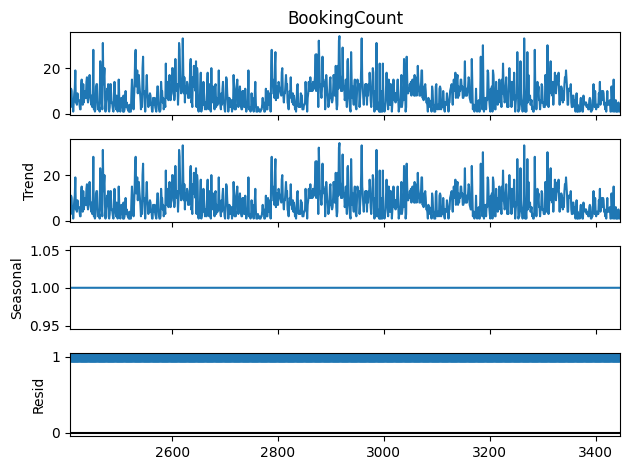

In [35]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'].interpolate(),
                                period=1,
                                model='multiplicative')
resplot = res.plot()

Here we can see the trend but absolute lack of seasonality.

In [36]:
res.resid[np.isfinite(res.resid) == False] = 0

In [37]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                period=52,
                                model='additive')

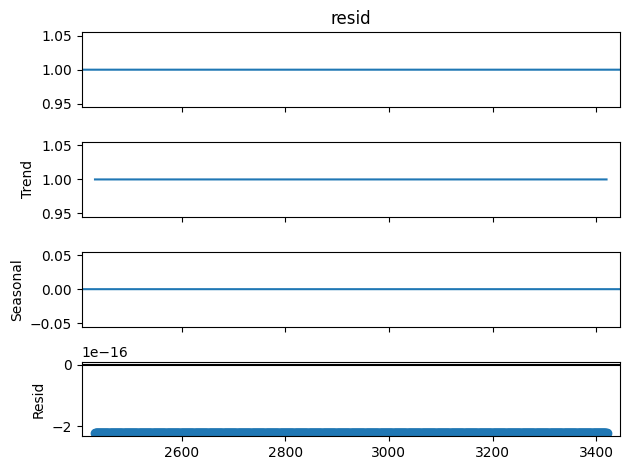

In [38]:
resplot = res_resid.plot()

## Anomaly detection.
An anomaly in a time series refers to a data point or sequence of data points that significantly deviates from the expected patterns or trends typically observed in the data. These anomalies can manifest in various ways, such as abrupt changes in values, an increase in NULL values, missing data segments, or other irregular patterns that deviate from normal fluctuations. As discussed in [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf), such anomalies can indicate significant events or issues within the system being analyzed. In our specific context, an anomaly might suggest that during certain periods, the demand exceeded the hotel's operational capacity.
Numerous techniques for anomaly detection have been evaluated in the literature. During our research, we identified an effective algorithm that can be applied to the residual component of a seasonal-trend decomposition, utilizing the Isolation Forest method. This approach is both efficient and fast. We propose this algorithm for anomaly detection at each hotel level, as inspired by the work on [Unsupervised Anomaly Detection on Server Metrics](https://webthesis.biblio.polito.it/21240/1/tesi.pdf).

#### Anomaly detection with Isolation Forest
The steps of the algorithm are:
1. Normalization of the time series
2. Seasonal trend decomposition of the time series to extract the residual.
3. Applying ISOLATION FOREST to the residual
4. Remove points not considered anomalous by the Isolation Forest
5. Apply DBSCAN to the points outside the confidence region to obtain clusters of points close to each other
6. Points that do not belong to any cluster are the anomalies

[Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179) algorithm directly seeks anomalous points based on the contamination parameter. First, the algorithm builds a forest of random decision trees. After training, it assigns an anomaly score to each data point. At this stage, we don't know whether a point is an inlier or outlier. The contamination parameter serves as a threshold, determining how many points are classified as outliers by converting these raw scores into inlier or outlier labels.

In [39]:
!pip install matplot statsmodels numpy

### 1. Normalization of time series
We will now proceed with analyzing the time series data from Hotel 008, as this dataset appears interesting. Specifically, the boxplot has revealed some outlier points exceeding the maximum threshold. At the conclusion of this analysis, we will write a function that can be applied to each hotel. We want to scale the data as to detect outliers we will use isolation forest, that require data scaling.

In [40]:
from sklearn.preprocessing import MinMaxScaler
# random forest requirement
# normalization scales each value of booking count to range 0.1
min_max_scaler = MinMaxScaler(feature_range=(0,1))
booking_count = hotel_data[['BookingCount']]
booking_count_scaled = min_max_scaler.fit_transform(booking_count)
hotel_data['BookingCount_Scaled'] = booking_count_scaled
booking_hotel_scaled = hotel_data.drop(columns=['HotelId'])

### 2. Seasonal-Trend decomposition using LOESS

Time series data can have a well known set of pattern.
Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
- Trend: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.
-  A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.
- Cyclice cycle occurs when the data exhibit rises and falls that are not of a fixed frequency.

Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data. An additive model is applied when the trend appears linear, and the seasonal and trend components remain relatively constant over time (e.g., each year, we add 1000 new booking). In contrast, a multiplicative model is more suitable when the data shows a non-linear growth or decline (e.g., doubling the number of bookings). Our interest in findining anomalies is to look in the residual, the difference of the trend effect with the seasonality component. In that subset of data might happen that there are errors due to series peak or seasonal bookings.

In [41]:
booking_hotel_scaled.head()

Arrival  BookingCount  BookingCount_Scaled
2407 2020-01-02             4             0.090909
2408 2020-01-03             4             0.090909
2409 2020-01-04            11             0.303030
2410 2020-01-05            10             0.272727
2411 2020-01-06             3             0.060606

<Axes: >

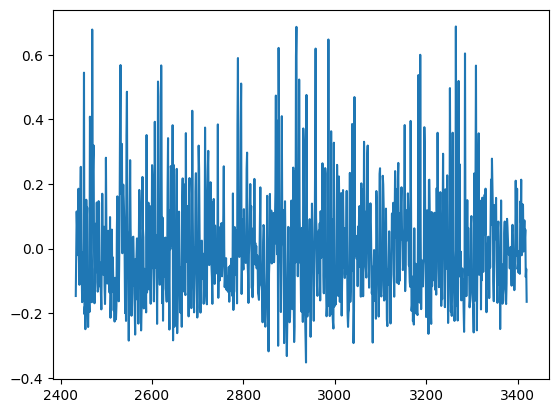

In [42]:
season_decomposed = sm.tsa.seasonal_decompose(booking_hotel_scaled['BookingCount_Scaled'].interpolate(),period=52)
residual = season_decomposed.resid
residual.plot()

### 3. Apply Isolation Forest on Residual


In [43]:
residual.head()

2407   NaN
2408   NaN
2409   NaN
2410   NaN
2411   NaN
Name: resid, dtype: float64

In [44]:
data = residual.fillna(residual.mean())
data.count()

1040

In [45]:
data.head()

2407    0.000515
2408    0.000515
2409    0.000515
2410    0.000515
2411    0.000515
Name: resid, dtype: float64

In [46]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
values = clf.fit_predict(data.values.reshape(-1, 1))
booking_hotel_scaled['anomaly_score'] = values
booking_hotel_scaled['is_anomaly'] = booking_hotel_scaled['anomaly_score'] == -1

In [47]:
booking_hotel_scaled.head(50)

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
2407 2020-01-02             4             0.090909              1       False
2408 2020-01-03             4             0.090909              1       False
2409 2020-01-04            11             0.303030              1       False
2410 2020-01-05            10             0.272727              1       False
2411 2020-01-06             3             0.060606              1       False
2412 2020-01-07             5             0.121212              1       False
2413 2020-01-08             1             0.000000              1       False
2414 2020-01-09             5             0.121212              1       False
2415 2020-01-10             9             0.242424              1       False
2416 2020-01-11            11             0.303030              1       False
2417 2020-01-12            19             0.545455              1       False
2418 2020-01-13             5             0.121212              1       False
2419 2020-01-14             6             0.151515              1       False
2420 2020-01-15             4             0.090909              1       False
2421 2020-01-16             9             0.242424              1       False
2422 2020-01-17             6             0.151515              1       False
2423 2020-01-18             6             0.151515              1       False
2424 2020-01-19             6             0.151515              1       False
2425 2020-01-20             4             0.090909              1       False
2426 2020-01-21             2             0.030303              1       False
2427 2020-01-22             2             0.030303              1       False
2428 2020-01-23            12             0.333333              1       False
2429 2020-01-24            15             0.424242              1       False
2430 2020-01-25             5             0.121212              1       False
2431 2020-01-26             4             0.090909              1       False
2432 2020-01-27            13             0.363636              1       False
2433 2020-01-28             5             0.121212              1       False
2434 2020-01-29             7             0.181818              1       False
2435 2020-01-30            10             0.272727              1       False
2436 2020-01-31             9             0.242424              1       False
2437 2020-02-01             7             0.181818              1       False
2438 2020-02-02            14             0.393939              1       False
2439 2020-02-03            16             0.454545             -1        True
2440 2020-02-04             7             0.181818              1       False
2441 2020-02-05             5             0.121212              1       False
2442 2020-02-06             7             0.181818              1       False
2443 2020-02-07            13             0.363636              1       False
2444 2020-02-08            17             0.484848             -1        True
2445 2020-02-09             8             0.212121              1       False
2446 2020-02-10             7             0.181818              1       False
2447 2020-02-11             4             0.090909              1       False
2448 2020-02-12             8             0.212121              1       False
2449 2020-02-13             3             0.060606              1       False
2450 2020-02-14             9             0.242424              1       False
2451 2020-02-15            28             0.818182             -1        True
2452 2020-02-16             2             0.030303             -1        True
2453 2020-02-17             3             0.060606              1       False
2454 2020-02-18             1             0.000000             -1        True
2455 2020-02-19             2             0.030303              1       False
2456 2020-02-21            12             0.333333              1       False

### 4. Remove the points that are not consided anomalies by IsolationForest.

In [48]:
hotel_anomalies = booking_hotel_scaled[booking_hotel_scaled['anomaly_score']==-1]
hotel_anomalies.head(46)

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
2439 2020-02-03            16             0.454545             -1        True
2444 2020-02-08            17             0.484848             -1        True
2451 2020-02-15            28             0.818182             -1        True
2452 2020-02-16             2             0.030303             -1        True
2454 2020-02-18             1             0.000000             -1        True
2460 2020-02-25             2             0.030303             -1        True
2463 2020-02-28             1             0.000000             -1        True
2464 2020-02-29            23             0.666667             -1        True
2465 2020-03-01            18             0.515152             -1        True
2469 2020-03-05            31             0.909091             -1        True
2471 2020-03-07            16             0.454545             -1        True
2472 2020-03-08            20             0.575758             -1        True
2489 2020-03-25             1             0.000000             -1        True
2499 2020-04-04            15             0.424242             -1        True
2509 2020-05-08             1             0.000000             -1        True
2516 2020-06-03             2             0.030303             -1        True
2518 2020-06-05             1             0.000000             -1        True
2521 2020-06-09             1             0.000000             -1        True
2530 2020-06-19            25             0.727273             -1        True
2531 2020-06-20            28             0.818182             -1        True
2532 2020-06-21            12             0.333333             -1        True
2533 2020-06-22            15             0.424242             -1        True
2534 2020-06-23            19             0.545455             -1        True
2537 2020-06-26            17             0.484848             -1        True
2541 2020-06-30             2             0.030303             -1        True
2543 2020-07-02             3             0.060606             -1        True
2544 2020-07-03            20             0.575758             -1        True
2545 2020-07-04            25             0.727273             -1        True
2549 2020-07-08             1             0.000000             -1        True
2552 2020-07-11            17             0.484848             -1        True
2555 2020-07-14             3             0.060606             -1        True
2563 2020-07-22             1             0.000000             -1        True
2570 2020-07-30             1             0.000000             -1        True
2576 2020-08-05             1             0.000000             -1        True
2579 2020-08-08            14             0.393939             -1        True
2587 2020-08-16             3             0.060606             -1        True
2588 2020-08-17            22             0.636364             -1        True
2600 2020-08-29            20             0.575758             -1        True
2601 2020-08-30            20             0.575758             -1        True
2606 2020-09-04            24             0.696970             -1        True
2611 2020-09-09             4             0.090909             -1        True
2613 2020-09-11            31             0.909091             -1        True
2614 2020-09-12            28             0.818182             -1        True
2620 2020-09-18            33             0.969697             -1        True
2621 2020-09-19            18             0.515152             -1        True
2624 2020-09-22             5             0.121212             -1        True

In [49]:
print(f'Anomalies count {hotel_anomalies.shape[0]} over {booking_hotel_scaled.shape[0]}')

Anomalies count 233 over 1040


### 5.Apply DBScan on the Isolation Forest Anomalies.
The points that don't belong to any cluster are anomalies and we can pass from 46 to much less. The eps is placed to 0.1. [DBScan](https://dl.acm.org/doi/10.1145/3068335) has num points and eps as hyperparameter. A better way to select the value of eps is described in [Fast Density-Based Clustering with R](https://www.jstatsoft.org/article/view/v091i01). The paper proposes using KNN to estimate the distance from each point to its nearest neighbor within the same partition, followed by sorting and selecting the minimum. However, we opted to use an empirical value derived from direct data exploration.

In [50]:
hotel_anomalies['Arrival_float'] = hotel_anomalies['Arrival'].apply(lambda x: x.timestamp())
hotel_anomalies.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
2439 2020-02-03            16             0.454545             -1        True   
2444 2020-02-08            17             0.484848             -1        True   
2451 2020-02-15            28             0.818182             -1        True   
2452 2020-02-16             2             0.030303             -1        True   
2454 2020-02-18             1             0.000000             -1        True   

      Arrival_float  
2439   1.580688e+09  
2444   1.581120e+09  
2451   1.581725e+09  
2452   1.581811e+09  
2454   1.581984e+09

In [51]:
from sklearn.cluster import DBSCAN
X = hotel_anomalies[['BookingCount_Scaled']].values
# min_samples defines the minimum number of data points required to form a distinct cluster
dbscan = DBSCAN(eps=0.1, min_samples=20)
dbscan.fit(X)
hotel_anomalies['Cluster'] = dbscan.labels_
outliers = hotel_anomalies[hotel_anomalies['Cluster'] == -1]
outliers.count()

Arrival                1
BookingCount           1
BookingCount_Scaled    1
anomaly_score          1
is_anomaly             1
Arrival_float          1
Cluster                1
dtype: int64

In [52]:
outliers.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
2916 2021-12-11            34                  1.0             -1        True   

      Arrival_float  Cluster  
2916   1.639181e+09       -1

In Italy August, December and beginning of January are typically vacation time so it is normal having anomalies.

In [53]:
from datetime import datetime
collect_idx_to_remove = []
for idx,value in outliers.iterrows():
    date = value[0].to_pydatetime()
    # we exclude december, august, and january till 6
    if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
        collect_idx_to_remove.append(idx)
outliers_cleaned = outliers.drop(index=collect_idx_to_remove)
outliers_cleaned.head()

<ipython-input-53-ef062bb7d7ee>:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Empty DataFrame
Columns: [Arrival, BookingCount, BookingCount_Scaled, anomaly_score, is_anomaly, Arrival_float, Cluster]
Index: []

Now we can act in two ways in case of forecasting:
- remove the outliers in case of error since
- evalutating when happens and if they are legit (high season, events, christmas) keep them.

We can remove safely the outliners except for the week of Christmas and First week of the year We can establish, having seen the data distribution that **peak are not anomalies** in:
1. Christmas period
2. First week of the year
3. August

Now we need to generalize for each hotel. We're gonna define a function **clean_time_series** in Python that include all the code we've see to clean up from outliers and a **restrict_outliers** that take in account the vacation times.

In [54]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from datetime import datetime
def restrict_outliers(outliers: pd.DataFrame) -> pd.DataFrame:
    collect_idx_to_remove = []
    for idx,value in outliers.iterrows():
        date = value[1].to_pydatetime()
        # we exclude december, august, and january till 6
        if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
            collect_idx_to_remove.append(idx)
    outliers.drop(index=collect_idx_to_remove)
    return outliers

# we can apply this function to each hotel to clean data
def clean_time_series(hd: pd.DataFrame) -> pd.DataFrame:
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    booking_count = hd[['BookingCount']]
    booking_count_scaled = min_max_scaler.fit_transform(booking_count)
    hd['BookingCount_Scaled'] = booking_count_scaled
    season_decomposed = sm.tsa.seasonal_decompose(hd['BookingCount_Scaled'].interpolate(),period=52)
    residual = season_decomposed.resid
    data = residual.fillna(residual.mean())
    clf = IsolationForest()
    values = clf.fit_predict(data.values.reshape(-1, 1))
    hd['anomaly_score'] = values
    hotel_anomalies = hd[hd['anomaly_score']==-1]
    X = hotel_anomalies[['BookingCount_Scaled']].values
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    dbscan.fit(X)
    hotel_anomalies['Cluster'] = dbscan.labels_
    outliers = restrict_outliers(hotel_anomalies[hotel_anomalies['Cluster'] == -1])
    hd = hd.drop(outliers.index.to_list())
    return hd


## Model Selection for Demand Score
Now we clean our scaled data to validate which model is better and then we start with model selection. We have to investigate between Facebook [Prophet](https://peerj.com/preprints/3190.pdf) and SARIMAX.


In [55]:
hotel_evaluation_ds = clean_time_series(hotel_data)

In [56]:
print(f'Series size after cleaning {hotel_evaluation_ds.shape[0]} and before {hotel_data.shape[0]}')

Series size after cleaning 1040 and before 1040


In [57]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


demand_ds = hotel_evaluation_ds[['Arrival','BookingCount']]
demand_ds['Arrival'] = pd.to_datetime(hotel_evaluation_ds['Arrival'])
demand_ds.head()

Arrival  BookingCount
2407 2020-01-02             4
2408 2020-01-03             4
2409 2020-01-04            11
2410 2020-01-05            10
2411 2020-01-06             3

### Descriptive Analytics on cleaned dataset
A lot of transformation has been effected the original data. So before passing to see Prophet and crafting model a bit of descriptive analytics is needed
on the resulting model. So we'd like to see:
- The behaviour in the first 12 months: trend and standard deviation
- ACF plots and PACF plots (https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb) that are useful to intepret a time series.

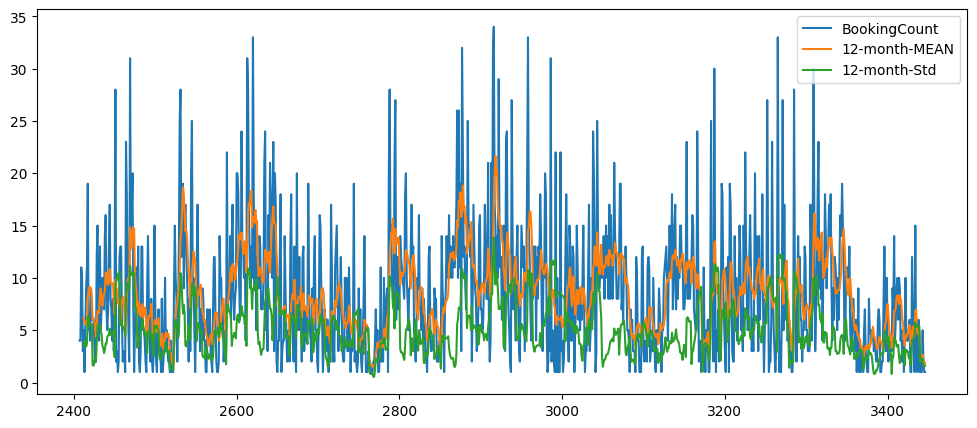

In [58]:
df = demand_ds.copy()
df['12-month-MEAN'] = df['BookingCount'].rolling(window=6).mean()
df['12-month-Std'] = df['BookingCount'].rolling(window=6).std()
df[['BookingCount','12-month-MEAN','12-month-Std']].plot(figsize=(12,5));


Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data.

An additive model is applied when the trend appears linear, and the seasonal and trend components remain relatively constant over time (e.g., each year, we add 10,000 passengers). In contrast, a multiplicative model is more suitable when the data shows a non-linear growth or decline (e.g., doubling the number of passengers each year). In our case as stated previously we use a multiplicative model.

In [59]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

In [60]:
demand_ds.reset_index()

index    Arrival  BookingCount
0      2407 2020-01-02             4
1      2408 2020-01-03             4
2      2409 2020-01-04            11
3      2410 2020-01-05            10
4      2411 2020-01-06             3
...     ...        ...           ...
1035   3442 2023-12-22             1
1036   3443 2023-12-23             5
1037   3444 2023-12-26             2
1038   3445 2023-12-27             1
1039   3446 2023-12-28             1

[1040 rows x 3 columns]

In [61]:
demand_ds.head()

Arrival  BookingCount
2407 2020-01-02             4
2408 2020-01-03             4
2409 2020-01-04            11
2410 2020-01-05            10
2411 2020-01-06             3

We have already seen the seasonal decomposition that in our case is multiplicative. We want to see the seasonality exploring the monthly plot and the existence of null values. We also need to check for stationarity since it is a requirement for SARIMAX.


#### Check for null and invalid values.

In [62]:
print(demand_ds[['BookingCount', 'Arrival']].isnull().sum())

BookingCount    0
Arrival         0
dtype: int64


In [63]:
#### Check for stationarity.

In [64]:
!pip install rich

In [196]:
import rich
from statsmodels.tsa.stattools import adfuller

def is_a_stationary_series(time_series):
    result = adfuller(time_series.values)
    stats = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {stats}')
    print(f'p-value: {p_value}')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (p_value <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [198]:
is_a_stationary_series(demand_ds['BookingCount'])

ADF Statistic: -5.811237036320058
p-value: 4.396440764401815e-07
Critical Values:
ADF Statistic: -5.811237
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Stationary


Stationary

The series is no stationary so any attempt to use classical series analysis like SARIMAX will fail.We will remove the non-stationarity before further analysis.

#### Monthly Plot, ACF, PACF

Now we plot the lags and the autocorrelation. A correct defintion comes from investopedia (represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.Autocorrelation measures the relationship between a variable's current value and its past values. It measures utocorrelation measures the relationship of a variable with lagged values of itself.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

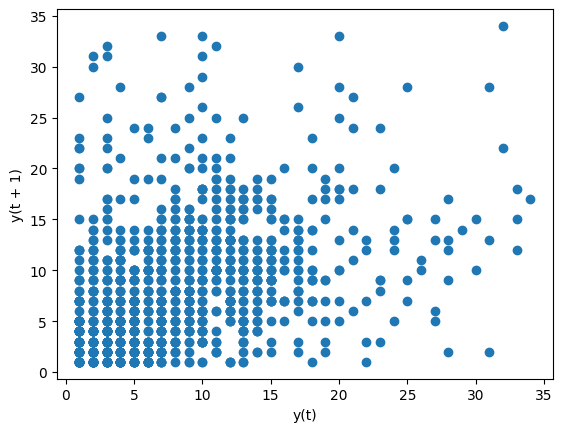

In [73]:
lag_plot(demand_ds['BookingCount'])

The data scatter we see a trend but not really a strong autocorrelation. Let's investigate more with ACF and PACF.

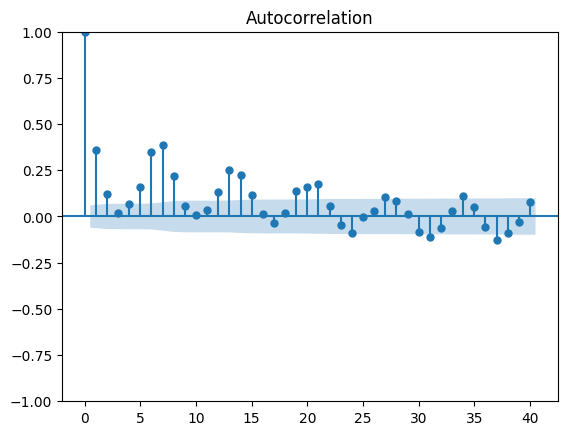

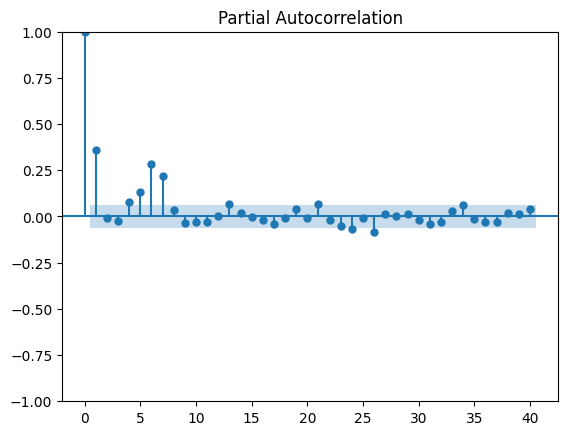

In [74]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(demand_ds['BookingCount'], lags=40)
plot_pacf(demand_ds['BookingCount'], lags=40)
plt.show()


Autocorrelation measures the linear relationship between lagged values. In the Autocorrelation plot we have several autocorrelation coefficient plotted together.
- When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.
- When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.
- When data are both trended and seasonal, you see a combination of these effects.

The value of the autocorrelation are in geneal very high indicating corrrelation at each lag, increases and decreaseas periodically without following a precise trend.
A time-series is [stationary](https://www.timescale.com/learn/stationary-time-series-analysis) statistical properities don't change over the time. This implies that the distribution's shape, spread, and central tendency remain consistent over time, regardless of when the observations were made.



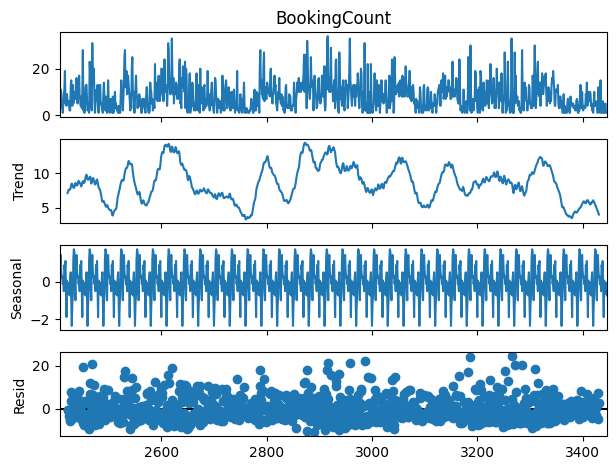

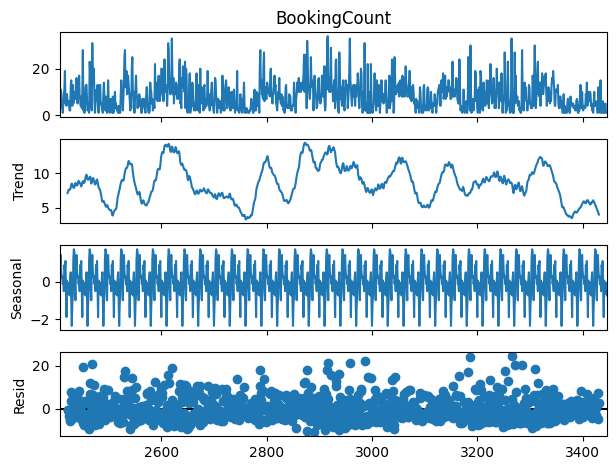

In [199]:
season = sm.tsa.seasonal_decompose(demand_ds['BookingCount'].interpolate(),period=30)
season.plot()

## Model building with Prophet.

[Prophet](https://facebook.github.io/prophet/) imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column). So, we must rename the columns in our dataframe.


In [75]:
prophet_ds = demand_ds.rename(columns={'Arrival': 'ds','BookingCount': 'y'})
prophet_ds.reset_index()
prophet_ds.head()

ds   y
2407 2020-01-02   4
2408 2020-01-03   4
2409 2020-01-04  11
2410 2020-01-05  10
2411 2020-01-06   3

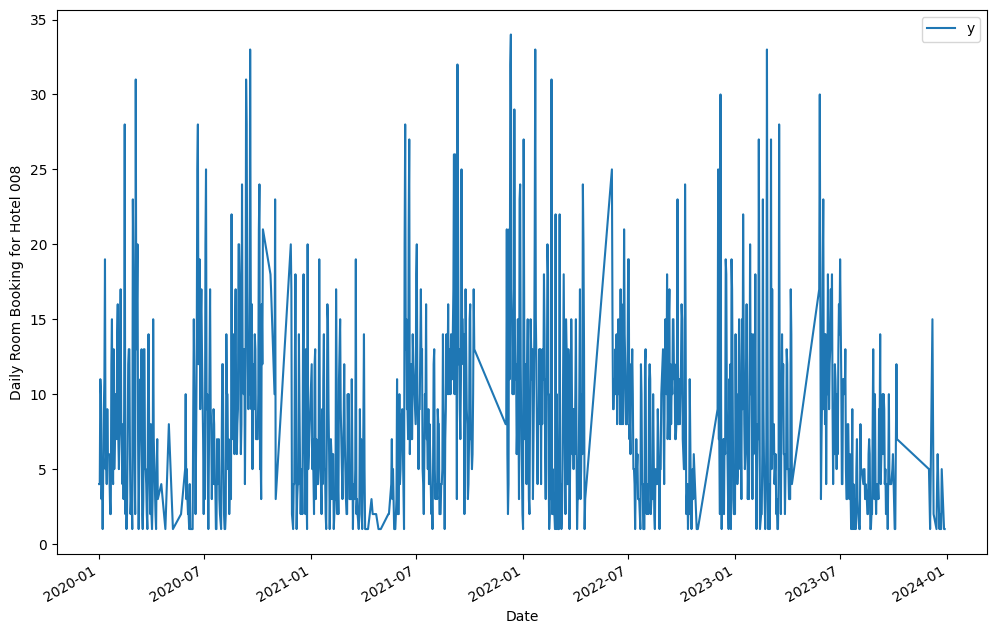

In [76]:
ax = prophet_ds.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Daily Room Booking for Hotel 008')
ax.set_xlabel('Date')
plt.show()

In [77]:
prophet_model = Prophet(interval_width=0.90)

In [78]:
model = prophet_model.fit(prophet_ds)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/6zjbcs48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/0g2l4_mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47558', 'data', 'file=/tmp/tmpsuzco773/6zjbcs48.json', 'init=/tmp/tmpsuzco773/0g2l4_mo.json', 'output', 'file=/tmp/tmpsuzco773/prophet_modelz354e9m7/prophet_model-20241028015915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Now we tell to Prophet to generate future dataset. Later we use the same method to aggregate data to compute demand score. The make_future_dataframe starts from the beginning of the dataset so we have to specify the exact number of weeks in period.

In [79]:
prophet_future_ds = model.make_future_dataframe(periods=60, freq='D')
prophet_future_ds.tail()

ds
1095 2024-02-22
1096 2024-02-23
1097 2024-02-24
1098 2024-02-25
1099 2024-02-26

In [80]:
prophet_demand_score_forecast = model.predict(prophet_future_ds)
prophet_demand_score_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2020-01-02   6.083432   -2.430384   13.852985
1 2020-01-03   9.737417    1.347394   18.468329
2 2020-01-04  12.118532    3.990380   20.061735
3 2020-01-05   7.976781   -0.284811   16.125851
4 2020-01-06   6.656380   -1.388373   15.477435

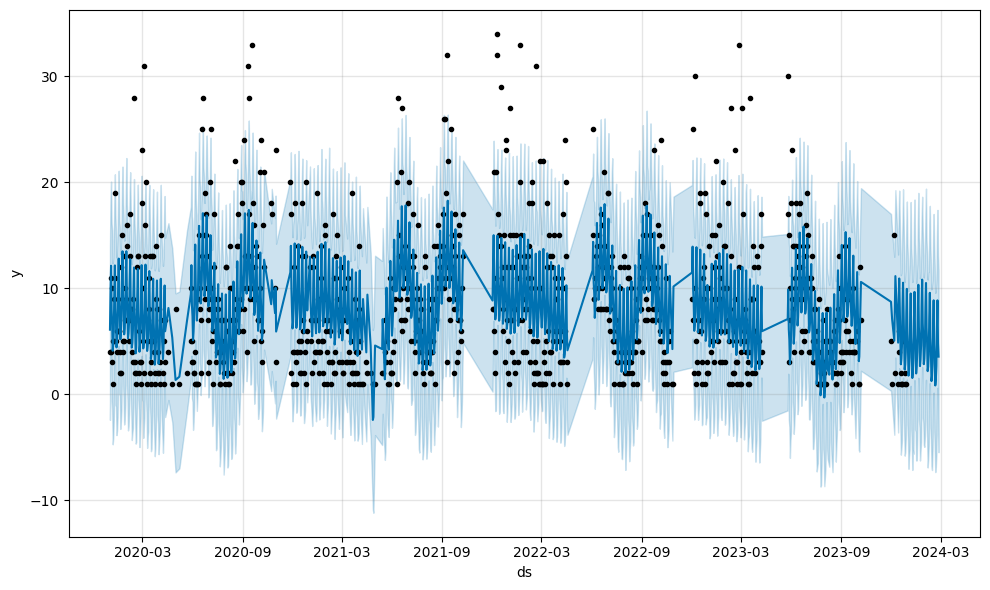

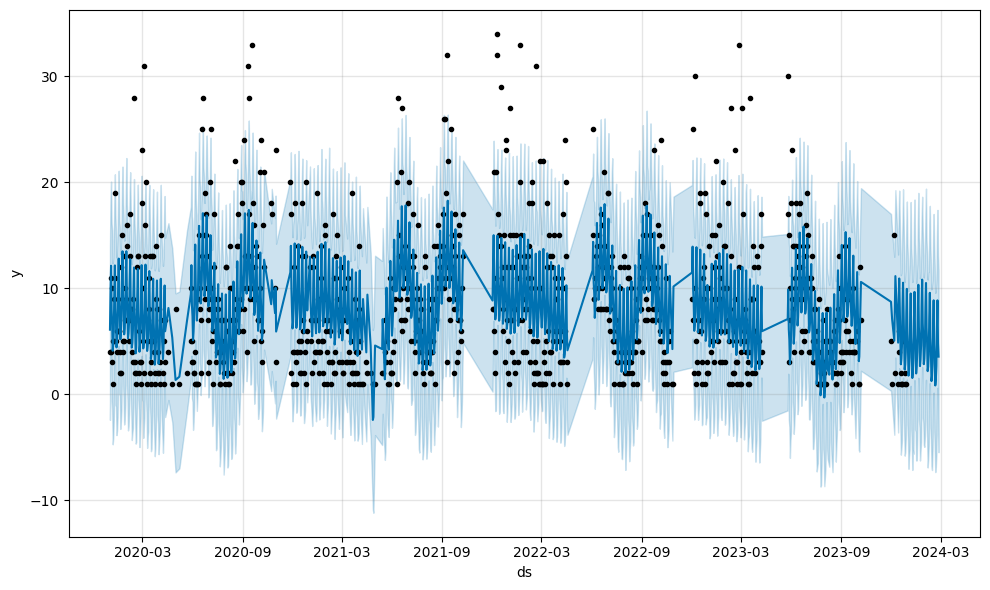

In [81]:
model.plot(prophet_demand_score_forecast, uncertainty=True)

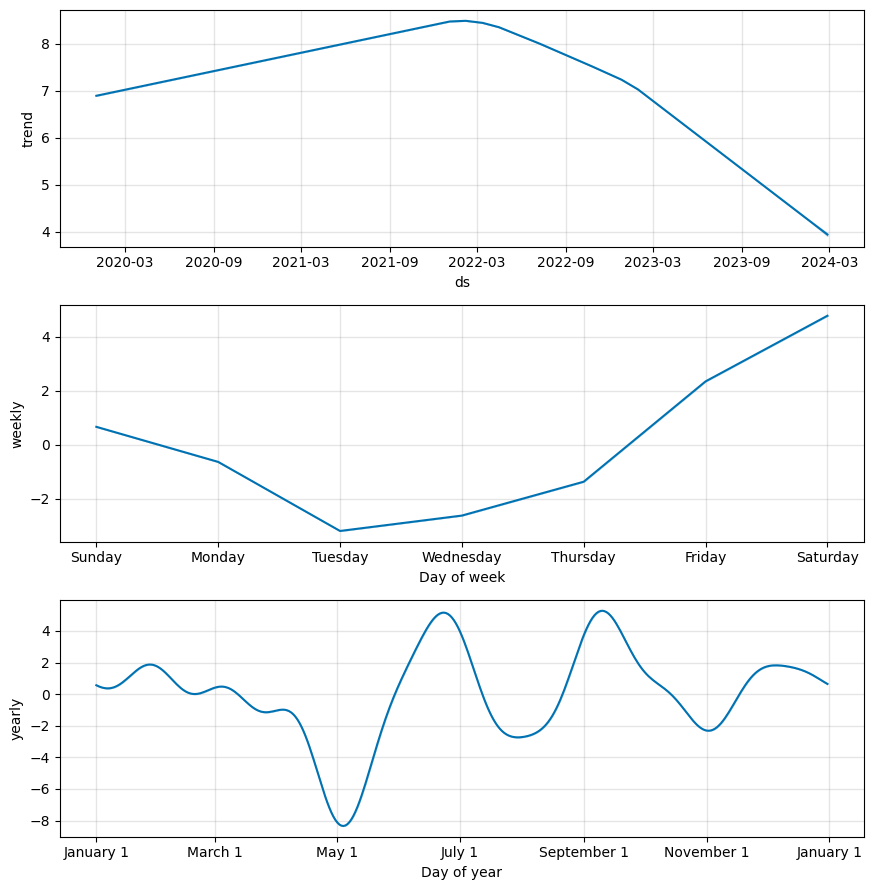

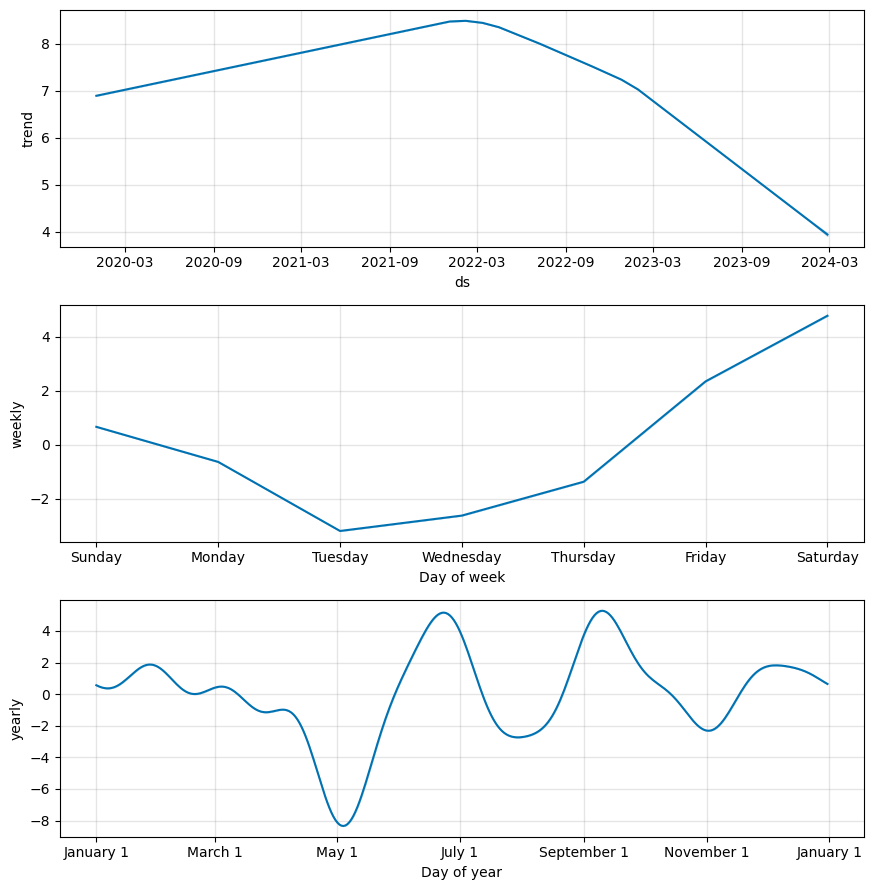

In [82]:
prophet_model.plot_components(prophet_demand_score_forecast)



In [83]:
# prophet has cross validaton
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, initial='500 days', period='10 days', horizon='10 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 73 forecasts with cutoffs between 2021-05-22 00:00:00 and 2023-12-18 00:00:00


  0%|          | 0/73 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/crxnoylv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/ixmdusey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33772', 'data', 'file=/tmp/tmpsuzco773/crxnoylv.json', 'init=/tmp/tmpsuzco773/ixmdusey.json', 'output', 'file=/tmp/tmpsuzco773/prophet_model88uj00c2/prophet_model-20241028015922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/_xtt0zo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/q013ycs1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

horizon        mse      rmse       mae      mape     mdape     smape  \
0  2 days  34.312599  5.857696  4.145607  0.865354  0.396319  0.530182   
1  3 days  28.975710  5.382909  4.222717  1.063416  0.415807  0.522498   
2  4 days  32.351574  5.687844  4.300280  1.233430  0.460103  0.579185   
3  5 days  28.228303  5.313031  4.219783  1.303190  0.400091  0.558515   
4  6 days  38.016352  6.165740  4.834547  1.085292  0.534144  0.613037   

   coverage  
0  0.865672  
1  0.869565  
2  0.910448  
3  0.894186  
4  0.823529

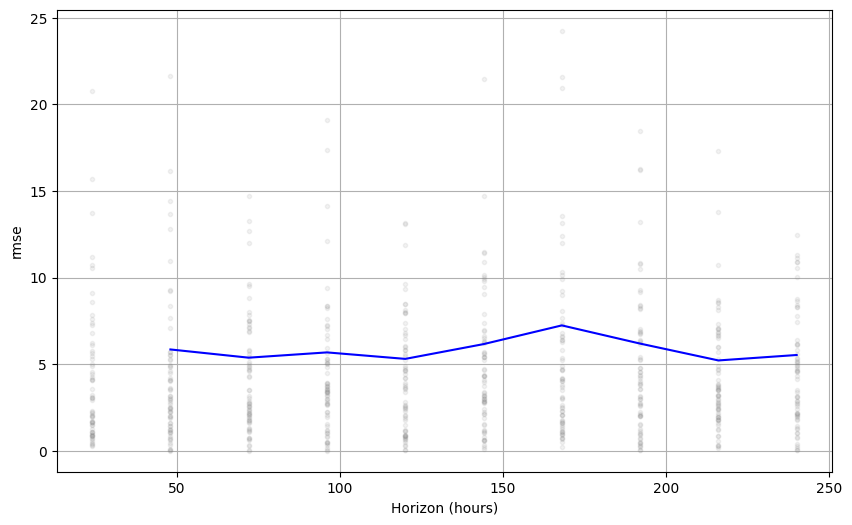

In [84]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


As it is the value of RMSE is too high, we need to install optuna and tune hyperparameters.

In [85]:
!pip install optuna

# Prophet Hyperparameter Tuning
Accordingly to prophet documentation, if we want to tune parameters, the first ones to be tunned should be:
1. **changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend and, in particular, how much the trend changes at the trend changepoints.
2. **seasonality_prior_scale**: This parameter controls the flexibility of the seasonality.
3. **holidays**: This controls flexibility to fit holiday effects.
4. **seasonality_mode**: Options are ['additive', 'multiplicative'].

We will use [Optuna](https://optuna.org/) for hyperparamter tuning. The main reason are the speed of execution and flexibility: it adapts to any machine learning model, it is written in Rust with python binding (so it is fast) and uses a different approach from GridSearch. Instead of exploring randomly the parameter space and trying to find the best uses an heuristic to prune the solutions and converge faster. It works in several step:
- define an objective function
- create a number of trials
- create study that trigger the trials
- find the best parameters as result ot that study.

First from [Prophet Hyperparamter documentation](https://facebook.github.io/prophet/docs/diagnostics.html) we see which are parameter interested to us.

In [86]:
import optuna


We insert all italian holidays so the time series model can take in account.

In [87]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2020-01-01', '2021-01-01','2022-01-01','2023-01-01'])})
befana = pd.DataFrame({'holiday': 'Befana', 'ds' : pd.to_datetime(['2020-01-06', '2021-01-06','2022-01-06','2023-01-06'])})
# Day in which italy has been freed by the nazis! Hasta la victoria siempre!
resistence_day = pd.DataFrame({'holiday': 'Resistence Day', 'ds' : pd.to_datetime(['2020-04-25', '2021-04-25','2022-04-25','2023-04-25'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2020-05-01', '2021-05-01', '2022-05-01','2023-05-01'])})
republic_day = pd.DataFrame({'holiday': 'Republic Day', 'ds' : pd.to_datetime(['2020-06-02', '2021-06-02', '2022-06-02','2023-06-02'])})
midsummer = pd.DataFrame({'holiday': "Midsummer Day", 'ds' : pd.to_datetime(['2020-08-15', '2021-08-15', '2022-08-15','2023-08-15'])})
maryday = pd.DataFrame({'holiday': 'St.Nicholas', 'ds' : pd.to_datetime(['2020-12-08', '2021-12-08','2022-12-09','2023-12-08'])})
christmas = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-25', '2021-12-25','2022-12-25','2023-12-25'])})
ststevenday=pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-26', '2021-12-26','2022-12-26','2023-12-26'])})
italian_public_holidays = pd.concat([ny, befana, resistence_day, lab, republic_day, midsummer, maryday, christmas,ststevenday])
italian_public_holidays.head()

holiday         ds
0  New Year's Day 2020-01-01
1  New Year's Day 2021-01-01
2  New Year's Day 2022-01-01
3  New Year's Day 2023-01-01
0          Befana 2020-01-06

Now we have to define the objective function using above parameters variation. Optuna has the concept of objective function to satisfy in order to perform early stopping.

In [88]:
def objective(trial):
    params = {
        'holidays': italian_public_holidays,  # Ensure this is a DataFrame with 'ds' and 'holiday' columns
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.2, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
    }

    m = Prophet(**params)
    m.add_seasonality(name='weekly', period=7, fourier_order=trial.suggest_int('weekly_seasonality', 5, 10))
    m.add_seasonality(name='yearly', period=365.25, fourier_order=trial.suggest_int('yearly_seasonality', 1, 20))

    m.fit(prophet_ds)

    number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 365
    if number_initial_days < 0:
        raise ValueError("Insufficient data for cross-validation")

    df_cv = cross_validation(m,
                             initial=f'{number_initial_days} days',
                             period='365 days',
                             horizon='365 days',
                             parallel="processes")

    df_p = performance_metrics(df_cv, rolling_window=1)
    if df_p.empty:
        raise ValueError("Cross-validation returned an empty performance metrics dataframe")

    return df_p['rmse'].values[0]


In [89]:
study = optuna.create_study(study_name="demandscore_prophet",direction='minimize')
# in production we can try up to 100 but in this case we limit to 10
study.optimize(objective, n_trials=10)

[I 2024-10-28 02:00:09,050] A new study created in memory with name: demandscore_prophet
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/i4gpe3rl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/b5k6p5ow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67399', 'data', 'file=/tmp/tmpsuzco773/i4gpe3rl.json', 'init=/tmp/tmpsuzco773/b5k6p5ow.json', 'output', 'file=/tmp/tmpsuzco773/prophet_modelu1q1bisn/prophet_model-20241028020009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:00:09 - cmdstanpy - INFO - Chain [1] start processing
IN

In [90]:
study.best_params

{'changepoint_prior_scale': 3.918566174941956,
 'changepoint_range': 0.516653328894662,
 'seasonality_prior_scale': 7.796195629343002,
 'holidays_prior_scale': 6.276597093582517,
 'seasonality_mode': 'additive',
 'weekly_seasonality': 10,
 'yearly_seasonality': 4}

## Prophet Cross Validation

In [91]:
prophet_model = Prophet(**study.best_params)
prophet_model.fit(prophet_ds)
number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 60
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='30 days', horizon='30 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/3ha6p7dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/9pafcyy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88293', 'data', 'file=/tmp/tmpsuzco773/3ha6p7dp.json', 'init=/tmp/tmpsuzco773/9pafcyy9.json', 'output', 'file=/tmp/tmpsuzco773/prophet_modelttoah9j0/prophet_model-20241028020105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:01:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2023-11-28 00:00:00 and 2023-11-28 00:00:00
INFO:prophet:Applying in parallel with <concu

horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  41.141078  6.414131  5.963764  3.571538  3.690581  1.153628   

   coverage  
0  0.733333

The Root Mean Square Error is acceptable, it is kind of 1 room every 10 days. It decreases when icrease the horizon.

In [92]:
number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 365
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='30 days', horizon='30 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

INFO:prophet:Making 9 forecasts with cutoffs between 2023-01-09 00:00:00 and 2023-11-28 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7b4c6ccd9d20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/f19xwwn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/c375i4ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/mubk5c2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13185', 'data', 'file=/tmp/tmpsuzco773/f19xwwn9.json', 'init=/tmp/tmpsuzco773/mubk5c2q.json', 'output', 'file=/tmp/tmpsuzco773/prophet_modelz1deecb4/prophet_model-20241028020110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsuzco773/_qhtougx.json
DEB

horizon       mse      rmse       mae      mape   mdape     smape  coverage
0 30 days  25.75386  5.074826  3.864705  1.020809  0.4443  0.556147  0.854626

The result after hyperparameter tuning are good. MAPE 1%, 4 booking of RMSE. MAPE indicates for [time series](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=forecasting-statistical-details)
the error in percentuage on forecasting whereas RMSE indicate the error over time of the time series.

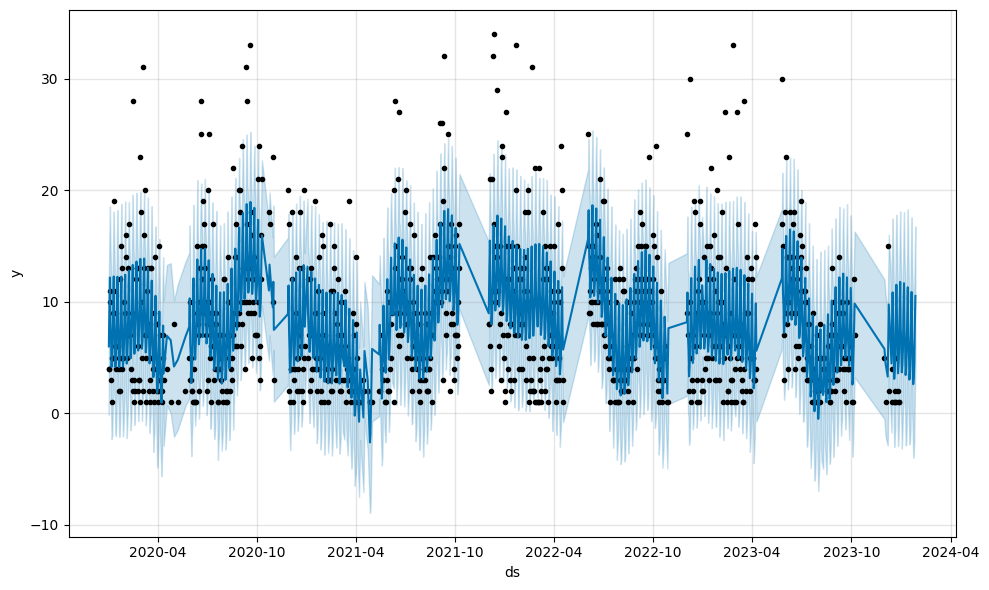

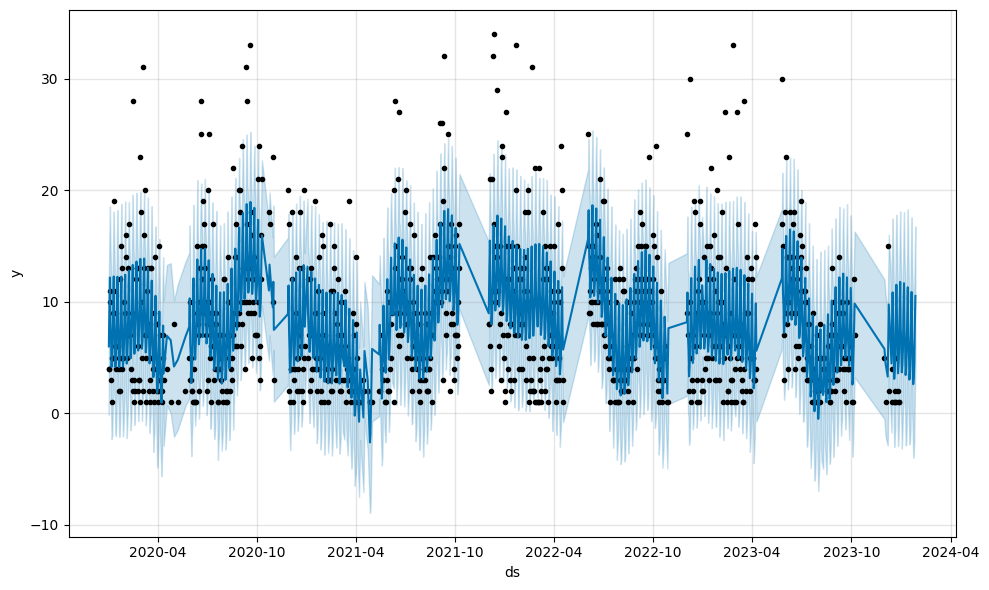

In [93]:
future_ds = model.make_future_dataframe(periods=30, freq='D')
forecast = prophet_model.predict(future_ds)
model.plot(forecast, uncertainty=True)

We are not entirely satisfied, as the prediction turns negative at a certain point in the tail. However, we can use the forecast to indicate the demand trend, and from this trend, we can calculate the score.


In [94]:
future_ds.tail()

ds
1065 2024-01-23
1066 2024-01-24
1067 2024-01-25
1068 2024-01-26
1069 2024-01-27

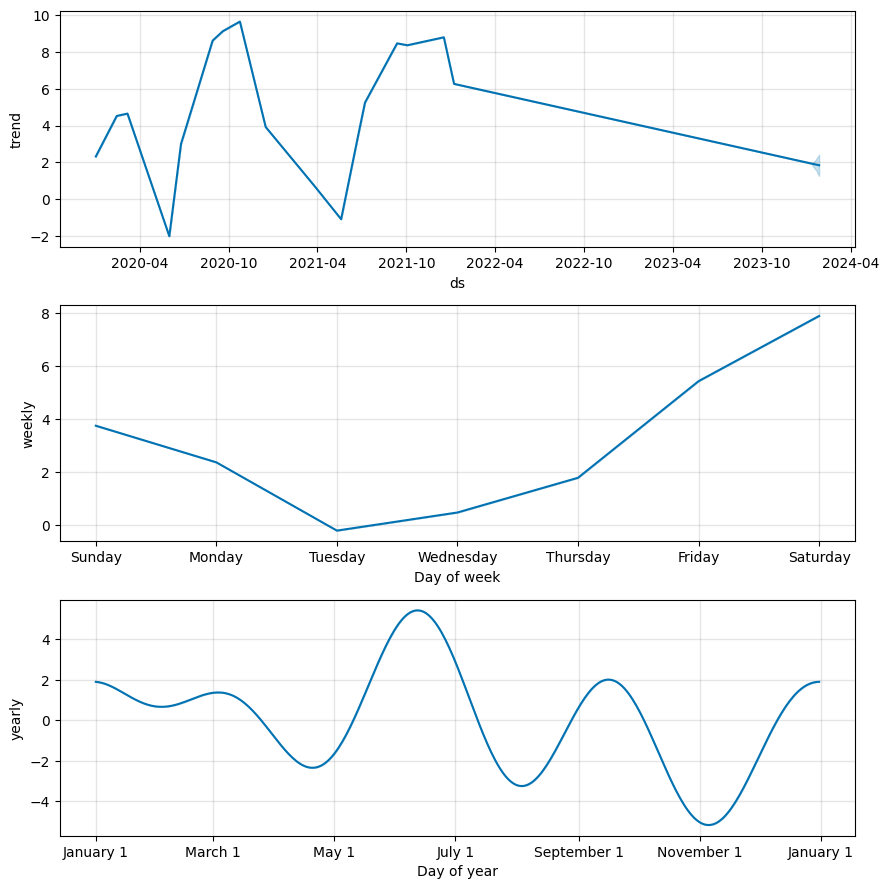

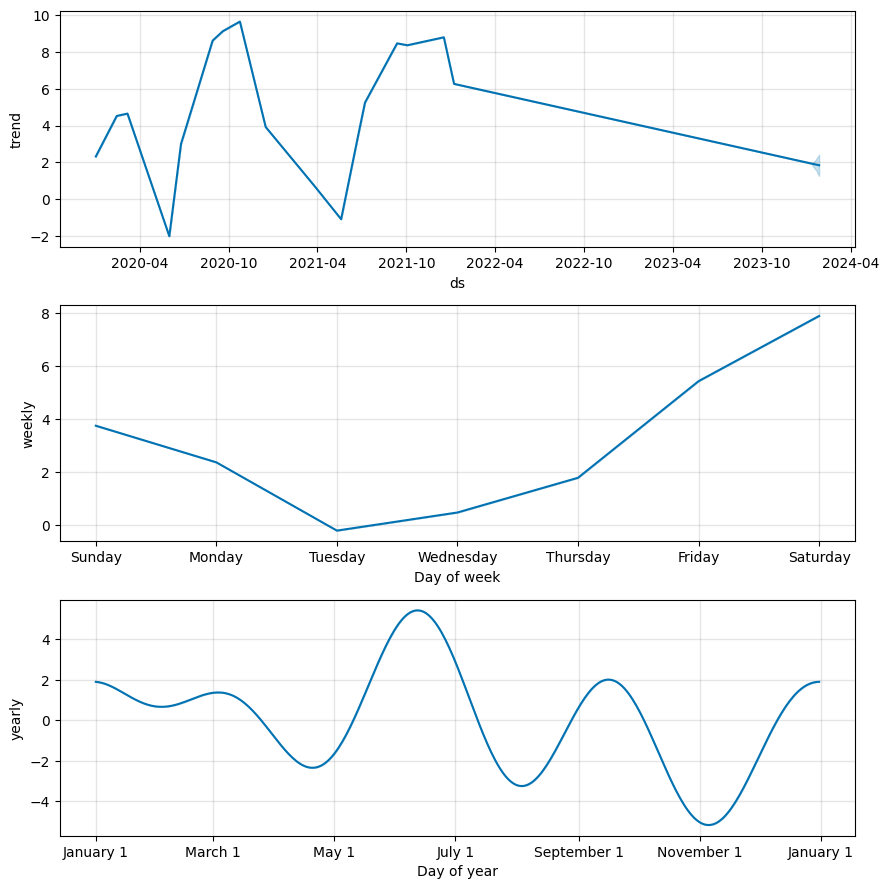

In [95]:
prophet_model.plot_components(forecast)

In [96]:
prophet_ds['y'].describe()

count    1040.000000
mean        8.476923
std         6.257965
min         1.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        34.000000
Name: y, dtype: float64

The mean of booked room in the dataset is 10, here the mape is 1, it means in the temporal window of 10 days the model can at least have an errors of 1% booking,that it is pretty fine for the problem.

Prophet works fine and easy to automate especially in presence of non-stationary series. Let's with SARIMAX we can obtain similar results.

In [97]:
## SARIMAX on stationary demand dataset

In [98]:
sarimax_ds = demand_ds.copy()
start_series = pd.to_datetime(sarimax_ds['Arrival'].min())
end_series = pd.to_datetime(sarimax_ds['Arrival'].max())
print(f"Series range {start_series} {end_series}")

Series range 2020-01-03 00:00:00 2023-12-28 00:00:00


We select two subset of the series range one for training and one for testing.

In [99]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
start, end = '2022-01-02', '2023-06-01'
index_demand_ds = sarimax.set_index('Arrival')
booking_series_train = index_demand_ds.loc[start:end]['BookingCount'].asfreq('D')
booking_series_train.fillna(0, inplace=True)
start, end = '2023-06-02', '2023-10-01'
booking_series_test = index_demand_ds.loc[start:end]['BookingCount'].asfreq('D')
am_order = (1,0,0)
seasonal_order = (2, 0, 0, 12)
model = SARIMAX(booking_series_train,order=am_order, seasonal_order=seasonal_order)
model = model.fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       BookingCount   No. Observations:                  516
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1681.285
Date:                            Mon, 28 Oct 2024   AIC                           3370.569
Time:                                    02:01:43   BIC                           3387.554
Sample:                                01-02-2022   HQIC                          3377.225
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3352      0.029    -11.483      0.000      -0.392      -0.278
ar.S.L12      -0.0550      0.046     -1.199      0.230      -0.145       0.035
ar.S.L24      -0.1610      0.056     -2.888      0.004      -0.270      -0.052
sigma2        39.5366      1.571     25.171      0.000      36.458      42.615
===================================================================================
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):               323.75
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.88
Prob(H) (two-sided):                  0.58   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Let's see the values of RMSE in this case.

In [100]:
#get the predictions and residuals
booking_series_test.fillna(booking_series_test.median(),inplace=True)
predictions = model.forecast(len(booking_series_test))
predictions = pd.Series(predictions, index=booking_series_test.index)
residuals = booking_series_test  - predictions
residuals.fillna(residuals.median(), inplace=True)
residuals.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 121 entries, 2023-06-02 to 2023-09-30
Freq: D
Series name: None
Non-Null Count  Dtype  
--------------  -----  
121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [101]:
len(booking_series_test)

121

In [102]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("Root mean squared error :- ",round(mean_squared_error(booking_series_test, residuals,squared=False),5))

Root mean squared error :-  0.50908


It can't be, there is something wrong. Let's investigate better with Optuna.

## SARIMAX Hyperparmeter tuning with Optuna
We proceed in this way:
- Generate all possible combinations of parameters
- Define an function objective (ie. minimize RMSE or MAPE).
- Create an optuna study to achieve the Goal:
  1. Iteratively fit the model with train data changing hyperparameters
  2. Check the residual from the predictons and the test data.

In [103]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [104]:
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
    model=SARIMAX(booking_series_train,order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
    mdl = model.fit(disp=0) #disp=0
    predictions = mdl.forecast(len(booking_series_test))
    predictions = pd.Series(predictions, index=booking_series_test.index)
    residuals = booking_series_test - predictions
    mse=np.sqrt(np.mean(residuals**2))
    accuracy=mse
    return accuracy

In [105]:
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=10)

[I 2024-10-28 02:01:44,375] A new study created in memory with name: no-name-fcf0e34b-a75a-48c3-8adb-750cf6128d8d
[I 2024-10-28 02:01:45,684] Trial 0 finished with value: 8.415990645568465 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 0, 0, 12), 'trend': 'ct'}. Best is trial 0 with value: 8.415990645568465.
[I 2024-10-28 02:01:58,033] Trial 1 finished with value: 28.886387268548845 and parameters: {'order': (0, 0, 0), 'seasonal_order': (2, 2, 0, 12), 'trend': 'c'}. Best is trial 0 with value: 8.415990645568465.
[I 2024-10-28 02:02:10,859] Trial 2 finished with value: 8.148550640001128 and parameters: {'order': (0, 2, 2), 'seasonal_order': (0, 0, 2, 12), 'trend': None}. Best is trial 2 with value: 8.148550640001128.
[I 2024-10-28 02:02:19,779] Trial 3 finished with value: 108.69059569252015 and parameters: {'order': (0, 2, 1), 'seasonal_order': (2, 0, 2, 12), 'trend': 'ct'}. Best is trial 2 with value: 8.148550640001128.
[I 2024-10-28 02:02:25,362] Trial 4 finished with val

In [106]:
trial=study.best_trial
print("RMSE: {}".format(trial.value))
print("best params for SARIMAX: {}".format(trial.params))


RMSE: 4.1596616776216555
best params for SARIMAX: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 2, 12), 'trend': 'n'}


This means that with this model we've a RMSE < 2 over a booking period of 4 months. This model is pretty good, but requires a stationary series. It is difficult to be automated to compute the score. We opt for Prophet.

## Computing Demand Score

For computing the demand score we apply the forecast and than see the trend and from the trend we get the mean we rescale to 100. With this we have defined a process for each hotel series, the algorithm is scattered in two phases: Data Cleaning, Training and Computing the score, basically the following steps. *So for each hotel:
1. Select the hotel booking
2. Clean the data and remove outliers of the last 24 months data.
3. Train the Prophet model using latest data timeframe.
4. Crossvalidate the model
5. Hyperparameter tuning with Optuna
6. Give to the model a forcast period
7. Check the trend on forecast data.
8. Compute the mean of the trend and rescale to 100.
9. Store the score in JSON in a storage with a timestamp to be used for computing HotelRank



In [107]:
import json
mean_trend =  forecast['trend'].mean()
demand_score = score = 100/ mean_trend
print(f'Demand score for Hotel008 is: {demand_score}')
outdata = {'score': demand_score, 'hotel_id': '008'}
with open('demand_score_001.json','w') as score:
    json.dump(outdata, score)
    print('Data written on storage')


Demand score for Hotel008 is: 22.51978130099856
Data written on storage


# Cancellation Score: Analysis on Cancellations

Our customer [Blastness](https://blastness.com) holds all booking inside a Property Management System for his clients. Each booking has three states (classes): *Cancelled, Confirmed, Modified*. Our objective is to find an algorithm to compute the cancellation score, based on cancellation forecasting. Most of the recent studies treated as a classification problem. The cancellation factors can depende on hotel, customers, booking and external factors. In our case will leave extrenal factor in the near future. Our goal is to predict the next booking trend for our customers and count the number of cancellation in a future temporal period and compute a score based on the number of cancellations forecasted.
As first step we want to review again the dataset in this classification context, encode categorical data and see results


In [108]:
hb_dataset.head()

Code  Status BookingChannel    Arrival  Departure  \
68186  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
68289  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
68239  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
68400  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
67400  2165812668/4071186490     0.0    Booking.com 2023-12-23 2023-12-30   

       Nights    Total PurchaseDate        LastModified HotelId  \
68186       7  4637.25   2023-06-04 2023-06-04 09:27:30     008   
68289       7  3892.05   2023-06-17 2023-06-17 18:09:53     008   
68239       7  2620.35   2023-06-11 2023-06-11 10:53:57     008   
68400       7  2766.15   2023-07-02 2023-07-02 16:35:28     008   
67400       0     0.00   2023-02-03 2023-05-10 23:21:21     008   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
68186  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
68289  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
68239  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
68400  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
67400  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   

        Purchase_Timestamp   City  Season  
68186  1685836800000000000  Olbia  Winter  
68289  1686960000000000000  Olbia  Winter  
68239  1686441600000000000  Olbia  Winter  
68400  1688256000000000000  Olbia  Winter  
67400  1675382400000000000  Olbia  Winter

The first thing we might meed for the cancellation score is add a new feature called *CancellationRatio* that take in account the number of cancellations per hotel.


In [109]:
cancellation_rate = hb_dataset.groupby("HotelId").agg(
    total_bookings=("Status", "size"),
    cancellations=("Status", lambda x: (x == 0).sum())
)
d = ({
    'HotelId':[],
    'CancRate' :[]
               })
cancellation_rate.reset_index()
for rate in cancellation_rate.iterrows():
    hotel_id = rate[0]
    rate = round(rate[1][1]/rate[1][0],2)
    d['HotelId'].append(hotel_id)
    d['CancRate'].append(rate)
frame = pd.DataFrame(d)
hb_dataset = hb_dataset.merge(frame)


We introduced the cancellation rate inorder to take in account the amount of cancellation per hotel in the global prediction.

We've noticed too many feature and some of them are dependent, our objective is to understand when a reservation is confirmed or cancelled. Let's try to reduce them thru PCA. We want to drop all dates and keep the timestamp since are numerical and spread informations. Let's identify again which are the numerical and which are the categorical before doing the PCA. Principal component analysis (PCA) reduces the number of dimensions in large datasets to principal components that retain most of the original information. It does this by transforming potentially correlated variables into a smaller set of variables, called principal components.

In [110]:
hb_dataset.describe()

Status                        Arrival  \
count  39340.000000                          39340   
mean       0.589553  2022-01-15 05:26:04.087442944   
min        0.000000            2020-01-01 00:00:00   
25%        0.000000            2021-06-03 00:00:00   
50%        1.000000            2022-04-29 00:00:00   
75%        1.000000            2022-09-25 00:00:00   
max        2.000000            2023-12-28 00:00:00   
std        0.525452                            NaN   

                           Departure        Nights         Total  \
count                          39340  39340.000000  39340.000000   
mean   2022-01-18 05:00:13.543467008      1.516548    396.177232   
min              2020-01-02 00:00:00      0.000000      0.000000   
25%              2021-06-06 00:00:00      0.000000      0.000000   
50%              2022-05-01 00:00:00      1.000000    144.900000   
75%              2022-09-28 00:00:00      2.000000    531.000000   
max              2024-01-04 00:00:00     30.000000  20124.000000   
std                              NaN      1.967660    667.932308   

                        PurchaseDate                   LastModified  \
count                          39340                          39340   
mean   2021-11-07 05:08:32.089476352  2021-11-12 00:25:43.714463488   
min              2019-03-22 00:00:00            2019-03-22 12:49:30   
25%              2021-02-08 00:00:00  2021-02-16 18:33:42.750000128   
50%              2022-02-18 00:00:00            2022-02-24 18:27:41   
75%              2022-08-23 06:00:00     2022-08-25 15:44:03.500000   
max              2023-07-02 00:00:00            2023-07-02 22:29:40   
std                              NaN                            NaN   

       Arrival_Timestamp  Departure_Timestamp         LastModified_Timestamp  \
count       3.934000e+04         3.934000e+04                          39340   
mean        1.642224e+18         1.642482e+18  2021-11-12 00:25:43.714463488   
min         1.577837e+18         1.577923e+18            2019-03-22 12:49:30   
25%         1.622678e+18         1.622938e+18  2021-02-16 18:33:42.750000128   
50%         1.651190e+18         1.651363e+18            2022-02-24 18:27:41   
75%         1.664064e+18         1.664323e+18     2022-08-25 15:44:03.500000   
max         1.703722e+18         1.704326e+18            2023-07-02 22:29:40   
std         3.238879e+16         3.238956e+16                            NaN   

       Purchase_Timestamp      CancRate  
count        3.934000e+04  39340.000000  
mean         1.636262e+18      0.427921  
min          1.553213e+18      0.050000  
25%          1.612742e+18      0.410000  
50%          1.645142e+18      0.410000  
75%          1.661234e+18      0.430000  
max          1.688256e+18      0.570000  
std          3.338754e+16      0.081296

In [111]:
hb_dataset.dtypes

Code                              object
Status                           float64
BookingChannel                    object
Arrival                   datetime64[ns]
Departure                 datetime64[ns]
Nights                             int64
Total                            float64
PurchaseDate              datetime64[ns]
LastModified              datetime64[ns]
HotelId                           object
Arrival_Timestamp                  int64
Departure_Timestamp                int64
LastModified_Timestamp    datetime64[ns]
Purchase_Timestamp                 int64
City                              object
Season                            object
CancRate                         float64
dtype: object

We notice that we've also categorical variables and some redudant features have been introduced. We will get rid of categorical variables.

In [112]:
canc_score_ds = hb_dataset[["Status","BookingChannel","Nights","Total","HotelId","Arrival_Timestamp","CancRate","Departure_Timestamp","Purchase_Timestamp","City","Season"]].copy()
canc_score_ds.sort_values(by=['Purchase_Timestamp','Arrival_Timestamp','Departure_Timestamp'])

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
19055     1.0           Sito       4  2458.40     010  1582156800000000000   
38935     0.0         Synxis       0     0.00     003  1598227200000000000   
38936     0.0         Synxis       0     0.00     003  1598227200000000000   
38740     0.0         Synxis       0     0.00     003  1631664000000000000   
8713      1.0        Expedia       4  1046.25     008  1579132800000000000   
...       ...            ...     ...      ...     ...                  ...   
95        1.0    Booking.com       2   473.04     008  1695427200000000000   
99        1.0           Sito       3   566.00     008  1695427200000000000   
31        1.0    Booking.com       3   820.14     008  1701907200000000000   
41        1.0    Booking.com       3   862.65     008  1701907200000000000   
3         1.0    Booking.com       7  2766.15     008  1703548800000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp      City  Season  
19055      0.41  1582502400000000000  1553212800000000000      Rome  Winter  
38935      0.57  1598486400000000000  1555977600000000000  Florence  Summer  
38936      0.57  1598486400000000000  1555977600000000000  Florence  Summer  
38740      0.57  1631923200000000000  1555977600000000000  Florence    Fall  
8713       0.55  1579478400000000000  1557360000000000000     Olbia  Winter  
...         ...                  ...                  ...       ...     ...  
95         0.55  1695600000000000000  1688256000000000000     Olbia    Fall  
99         0.55  1695686400000000000  1688256000000000000     Olbia    Fall  
31         0.55  1702166400000000000  1688256000000000000     Olbia  Winter  
41         0.55  1702166400000000000  1688256000000000000     Olbia  Winter  
3          0.55  1704153600000000000  1688256000000000000     Olbia  Winter  

[39340 rows x 11 columns]

In [113]:
canc_score_ds['Status']

0        1.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
39335    1.0
39336    1.0
39337    0.0
39338    0.0
39339    1.0
Name: Status, Length: 39340, dtype: float64

Status will be our target variable since we're interested in Cancelled bookings.

In [114]:
canc_score_ds.isnull().sum()

Status                 0
BookingChannel         0
Nights                 0
Total                  0
HotelId                0
Arrival_Timestamp      0
CancRate               0
Departure_Timestamp    0
Purchase_Timestamp     0
City                   0
Season                 0
dtype: int64

Great not null valie. We're interested in general statistics.

In [115]:
canc_score_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39340 entries, 0 to 39339
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Status               39340 non-null  float64
 1   BookingChannel       39340 non-null  object 
 2   Nights               39340 non-null  int64  
 3   Total                39340 non-null  float64
 4   HotelId              39340 non-null  object 
 5   Arrival_Timestamp    39340 non-null  int64  
 6   CancRate             39340 non-null  float64
 7   Departure_Timestamp  39340 non-null  int64  
 8   Purchase_Timestamp   39340 non-null  int64  
 9   City                 39340 non-null  object 
 10  Season               39340 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


In [116]:
numerical_features = canc_score_ds.select_dtypes(include='number')
numerical_features.head()

Status  Nights    Total    Arrival_Timestamp  CancRate  \
0     1.0       7  4637.25  1703721600000000000      0.55   
1     1.0       7  3892.05  1703635200000000000      0.55   
2     1.0       7  2620.35  1703548800000000000      0.55   
3     1.0       7  2766.15  1703548800000000000      0.55   
4     0.0       0     0.00  1703289600000000000      0.55   

   Departure_Timestamp   Purchase_Timestamp  
0  1704326400000000000  1685836800000000000  
1  1704240000000000000  1686960000000000000  
2  1704153600000000000  1686441600000000000  
3  1704153600000000000  1688256000000000000  
4  1703894400000000000  1675382400000000000

## Exploratory Data Analysis for Cancellation Score
The first thing that we want to see is the distribution of target variable in our dataset. We notice that it has a binomial, customers in this dataset has a fixed probability of make a booking or not.  The state 1 is booking, 0 cancellatin and 2 modification. We also see that our customers tends to modify the reservation (postpone/change) in small percentuage of cases. Our intent here is to understand how the target variable works and then seen its relationship with other variables.

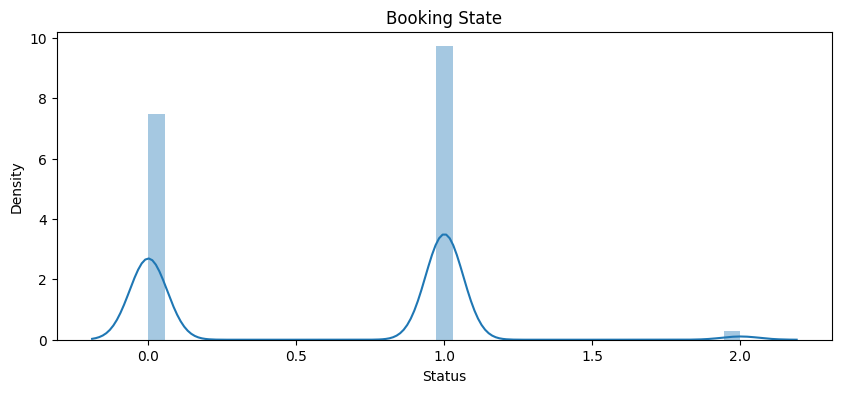

In [117]:
y_target = canc_score_ds['Status']
plt.figure(figsize= (10,4))
sns.distplot(y_target)
plt.title("Booking State")
plt.show()

We want to explore the relation between the target variable and the features. We see from the plot distribution are confirmed and once booked a modification is a rare event.

In [118]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['Arrival_Timestamp', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Arrival_Timestamp", y="Count", color="Status", width=800, height=600,
             labels={"Arrival_Timestamp": "Customer Arrival Timestamp", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per Customer Arrival")
fig.show()

It is interesting to see that there some gaps in the arrival due to the periodic behaviour of the bookings and most of the arrival are confirmed.

Now we want to see the cancellation status and its relationship with the city. It is interesting to see that in Rome all reservation has been confirmed.

In [119]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['City', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="City", y="Count", color="Status", width=800, height=800,
             labels={"City": "Hotel City", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per City")
fig.show()


Which is the relationship between status and nights?

In [120]:
import plotly.express as px
grouped_data = canc_score_ds.groupby(['Nights', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Nights", y="Count", color="Status", width=800, height=600,
             labels={"Nights": "Number of Nights", "Count": "Booking Count", "Status": "Booking Status"},
             title="Booking Status by Number of Nights")
fig.show()

As expected all cancelled have 0 night most of the night of arrival range beteen 1 (most of the confirmed), some moodification or variation of
the booking status appears with customers that have 1 or 2  night, over 5 nights is rare any change of state. Now we would like to know which is the Status relationship and cancellation rate.

In [121]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['Status', 'CancRate']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="CancRate", y="Count", color="Status", width=800, height=800,
             labels={"CancRate": "Hotel Cancellation Rate", "Count": "CancRate Aggregate", "Status": "Booking Status"},
             title="Distribution of Cancellation Rate")
fig.show()

In [122]:
y_target.describe()

count    39340.000000
mean         0.589553
std          0.525452
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Status, dtype: float64

In [123]:
y_target.skew()

-0.00920501598476925

In [124]:
y_target.kurtosis()

-1.230154350134033

The target variable is skewed with tenedency to the booking confirmation.

## Cancellation Score: Numerical Feature Distribution.
Here we show the distribution of numerical features.

<Figure size 1200x900 with 0 Axes>

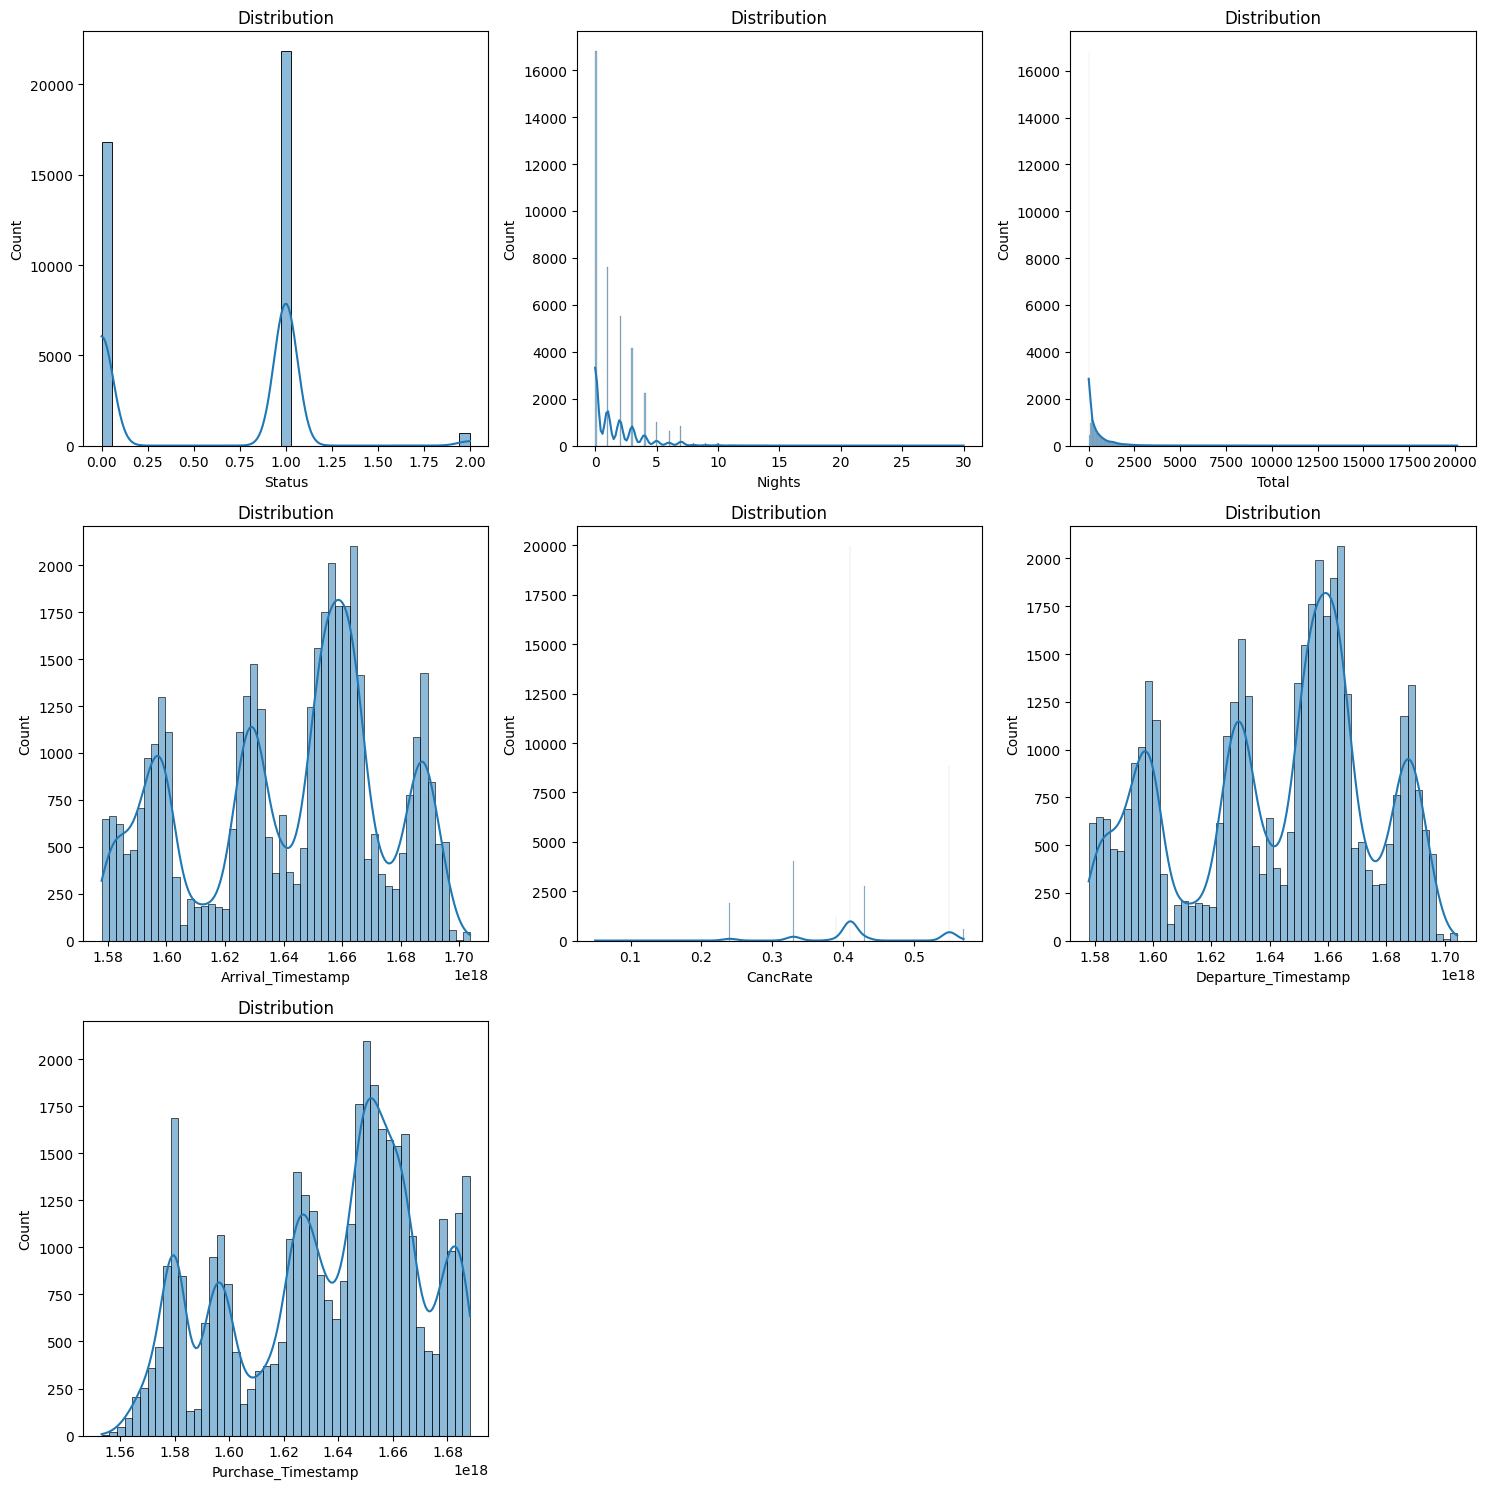

In [125]:
# Visualize the distribution of each feature
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 9))
features = numerical_features


# Create a histogram for each feature
num_features = len(features.columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(15, num_rows * 5))  # Adjust the figure size

for i, feature in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data=features, x=feature, kde=True)
    plt.title(f'Distribution')

plt.tight_layout()
plt.show()

All the date in function of the bookings has a binomial cyclic behavior when there is demand, the behaviour is binomial, and it is independent from the
cities. There is a gap of data from the Hotel in Rome. Generally most of the confirmed reservations are in Summer.

## Encoding Categorical Features.

In [126]:
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     008  1703721600000000000   
1         1.0    Booking.com       7  3892.05     008  1703635200000000000   
2         1.0    Booking.com       7  2620.35     008  1703548800000000000   
3         1.0    Booking.com       7  2766.15     008  1703548800000000000   
4         0.0    Booking.com       0     0.00     008  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1013.97     001  1592006400000000000   
39336     1.0           Sito      14  1108.40     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp   City  Season  
0          0.55  1704326400000000000  1685836800000000000  Olbia  Winter  
1          0.55  1704240000000000000  1686960000000000000  Olbia  Winter  
2          0.55  1704153600000000000  1686441600000000000  Olbia  Winter  
3          0.55  1704153600000000000  1688256000000000000  Olbia  Winter  
4          0.55  1703894400000000000  1675382400000000000  Olbia  Winter  
...         ...                  ...                  ...    ...     ...  
39335      0.34  1593216000000000000  1580169600000000000   Rome  Summer  
39336      0.34  1593216000000000000  1580169600000000000   Rome  Summer  
39337      0.34  1591056000000000000  1590451200000000000   Rome  Spring  
39338      0.34  1590883200000000000  1579219200000000000   Rome  Spring  
39339      0.34  1590364800000000000  1590192000000000000   Rome  Spring  

[39340 rows x 11 columns]

In [127]:
canc_score_ds['Status'].value_counts()

Status
1.0    21851
0.0    16818
2.0      671
Name: count, dtype: int64

We have 16818 cancellations, 21851  confirmations and only 671 modification. The dataset is unbalanced as we might expect in real world in this business scenario. The dataset is unbalanced and we are going to use Random Forest. The plan is to balance the dataset with SMOTE and then doing the PCA to reduce the dimensionality. Before we need to encode categorical values.

In [128]:
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     008  1703721600000000000   
1         1.0    Booking.com       7  3892.05     008  1703635200000000000   
2         1.0    Booking.com       7  2620.35     008  1703548800000000000   
3         1.0    Booking.com       7  2766.15     008  1703548800000000000   
4         0.0    Booking.com       0     0.00     008  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1013.97     001  1592006400000000000   
39336     1.0           Sito      14  1108.40     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp   City  Season  
0          0.55  1704326400000000000  1685836800000000000  Olbia  Winter  
1          0.55  1704240000000000000  1686960000000000000  Olbia  Winter  
2          0.55  1704153600000000000  1686441600000000000  Olbia  Winter  
3          0.55  1704153600000000000  1688256000000000000  Olbia  Winter  
4          0.55  1703894400000000000  1675382400000000000  Olbia  Winter  
...         ...                  ...                  ...    ...     ...  
39335      0.34  1593216000000000000  1580169600000000000   Rome  Summer  
39336      0.34  1593216000000000000  1580169600000000000   Rome  Summer  
39337      0.34  1591056000000000000  1590451200000000000   Rome  Spring  
39338      0.34  1590883200000000000  1579219200000000000   Rome  Spring  
39339      0.34  1590364800000000000  1590192000000000000   Rome  Spring  

[39340 rows x 11 columns]

### Create dummies for cities.

In [129]:
canc_score_ds = pd.concat([canc_score_ds, pd.get_dummies(canc_score_ds[["City"]])], axis=1)
canc_score_ds = canc_score_ds.drop(labels=["City"], axis=1)
canc_score_ds.reset_index()
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     008  1703721600000000000   
1         1.0    Booking.com       7  3892.05     008  1703635200000000000   
2         1.0    Booking.com       7  2620.35     008  1703548800000000000   
3         1.0    Booking.com       7  2766.15     008  1703548800000000000   
4         0.0    Booking.com       0     0.00     008  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1013.97     001  1592006400000000000   
39336     1.0           Sito      14  1108.40     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp  Season  \
0          0.55  1704326400000000000  1685836800000000000  Winter   
1          0.55  1704240000000000000  1686960000000000000  Winter   
2          0.55  1704153600000000000  1686441600000000000  Winter   
3          0.55  1704153600000000000  1688256000000000000  Winter   
4          0.55  1703894400000000000  1675382400000000000  Winter   
...         ...                  ...                  ...     ...   
39335      0.34  1593216000000000000  1580169600000000000  Summer   
39336      0.34  1593216000000000000  1580169600000000000  Summer   
39337      0.34  1591056000000000000  1590451200000000000  Spring   
39338      0.34  1590883200000000000  1579219200000000000  Spring   
39339      0.34  1590364800000000000  1590192000000000000  Spring   

       City_Brindisi  City_Chamonix-Mont-Blanc  City_Florence  City_Latina  \
0              False                     False          False        False   
1              False                     False          False        False   
2              False                     False          False        False   
3              False                     False          False        False   
4              False                     False          False        False   
...              ...                       ...            ...          ...   
39335          False                     False          False        False   
39336          False                     False          False        False   
39337          False                     False          False        False   
39338          False                     False          False        False   
39339          False                     False          False        False   

       City_Naples  City_Olbia  City_Rome  
0            False        True      False  
1            False        True      False  
2            False        True      False  
3            False        True      False  
4            False        True      False  
...            ...         ...        ...  
39335        False       False       True  
39336        False       False       True  
39337        False       False       True  
39338        False       False       True  
39339        False       False       True  

[39340 rows x 17 columns]

### Encode Booking Channel, Season and HotelId

In [130]:
channel_names = set(canc_score_ds['BookingChannel'].to_list())
season_names = set(canc_score_ds['Season'].to_list())
hotel_ids = set(canc_score_ds['HotelId'].to_list())
channel_mapper = {}
season_mapper = {}
hotel_id_mapper = {}
for code, name in enumerate(channel_names):
    if name not in channel_mapper:
        channel_mapper[name] = code
for code, season in enumerate(season_names):
    if season not in season_mapper:
        season_mapper[season] = code
for hid, hotelid in enumerate(hotel_ids):
    if hotelid not in hotel_id_mapper:
        hotel_id_mapper[hotelid] = hid
canc_score_ds['SeasonNumeric'] = canc_score_ds['Season'].map(season_mapper)
canc_score_ds['ChannelNumeric'] = canc_score_ds['BookingChannel'].map(channel_mapper)
canc_score_ds['HotelIdNumeric'] = canc_score_ds['HotelId'].map(hotel_id_mapper)
canc_score_ds.drop(labels=['BookingChannel','Season','HotelId'], axis=1, inplace=True)
print(f"Mappings {hotel_id_mapper}")

Mappings {'007': 0, '008': 1, '010': 2, '009': 3, '003': 4, '002': 5, '004': 6, '006': 7, '005': 8, '001': 9}


Now we've all variables categorical and we can try investigate about feature selection. We apply Univariate feature selection to see if the dimensionality can ben reduced.

# Univariate feature selection.
The key idea is to look after thee relationship between features and see if the there are relevant statistical relationship. The feature will be discared
when it doesn't add value to the classification. This method comes from [Muller & Guido](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/) book.

In [131]:
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

In [132]:
canc_score_X = canc_score_ds.drop(columns=['Status'])
canc_score_Y = canc_score_ds[['Status']]
num_cols = len(canc_score_X.columns)
print(f"Number of dependent variables {num_cols}")

Number of dependent variables 16


In [133]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(canc_score_X), 8))
X_w_noise = np.hstack([canc_score_X, noise])
# the first features are from the data set the rest 8 are noise
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, canc_score_Y, random_state=0,test_size=.5)
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print("Number of original features: {}".format(X_train.shape))
print("Number of selected feaures: {}".format(X_train_selected.shape))


Number of original features: (19670, 24)
Number of selected feaures: (19670, 12)


We've reduced the features this indicate there is redundancy, as method per dimensionality reduction that fits better with Random Forest we prefere PCA since we believe that we can obtain more.

## Anomaly detection: Outliers.

Outliers are data points that significantly deviate from the majority of the data. They can be caused by errors, anomalies, or simply rare events. Outlies can lead to overfitting. Outliers may lead to overfitting if the model tries to fit them perfectly, thus capturing their noise rather than the actual patterns in the data. We decided to replace outliers with the mean. For detecting outliners in classification problem we use Isolation Forest.
Isolation Forest The algoritm builds a random forest in which each decision tree is grown randomly: at each node, it pickes a feature randomly, the it picks a random threasold value to split the dataset in two. This process is repeated until all instances are isolated. Anomalies are usually far from other instances, so on average they tend to get isolated in fewer steps then normal instances. Once we've indentified the outliners we select and drop them. It's not the best approach since we risk underfit doing but the number is not meaniful in our case, we can drop. Alternative strategy could be repleace with the mean.


In [134]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
features = canc_score_ds.drop(columns=['Status'])
sca = StandardScaler()
X_train = sca.fit_transform(features)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
canc_score_ds['outlier'] = iso_forest.fit_predict(X_train)
outliers = canc_score_ds[canc_score_ds['outlier'] == -1]
inliers = canc_score_ds[canc_score_ds['outlier'] == 1]
# Display the number of outliers detected
print(f"Number of outliers detected: {len(outliers)}")


Number of outliers detected: 3934


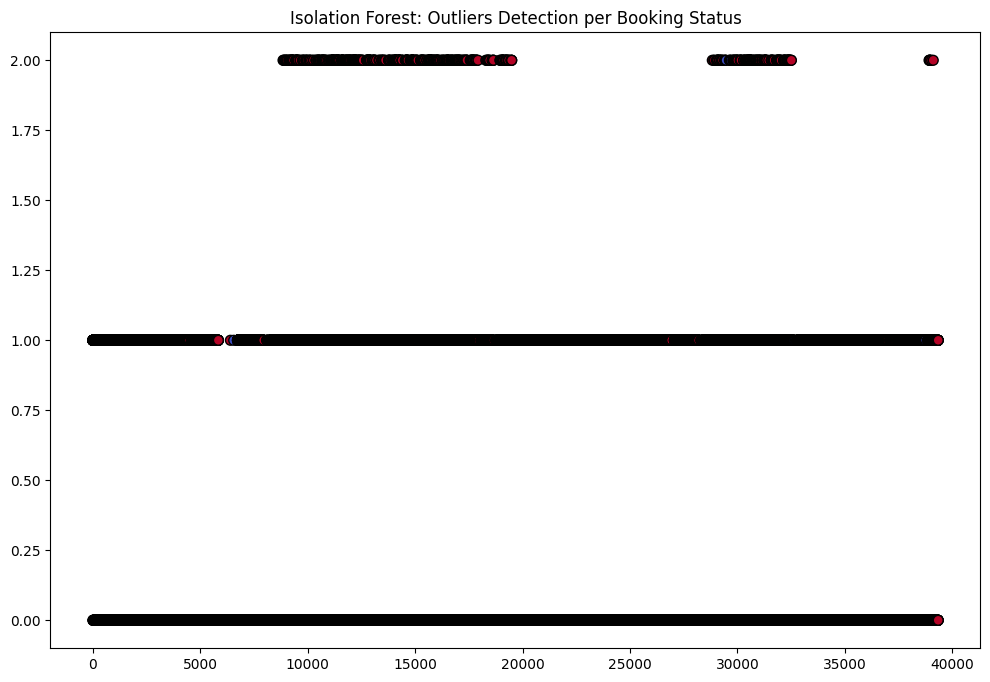

In [135]:
# Plot the inliers and outliers
plt.figure(figsize=(12, 8))
plt.scatter(canc_score_ds.index, canc_score_ds['Status'], c=canc_score_ds['outlier'], cmap='coolwarm', edgecolor='k', s=50)
plt.title('Isolation Forest: Outliers Detection per Booking Status')
plt.show()


In [136]:
canc_score_ds.count()

Status                      39340
Nights                      39340
Total                       39340
Arrival_Timestamp           39340
CancRate                    39340
Departure_Timestamp         39340
Purchase_Timestamp          39340
City_Brindisi               39340
City_Chamonix-Mont-Blanc    39340
City_Florence               39340
City_Latina                 39340
City_Naples                 39340
City_Olbia                  39340
City_Rome                   39340
SeasonNumeric               39340
ChannelNumeric              39340
HotelIdNumeric              39340
outlier                     39340
dtype: int64

We decide to remove and drop the outliers instead of replacing with the median. We lose only 10% of infromation on more than 40000 bookings.

In [137]:
canc_score_ds = canc_score_ds.drop(columns=['outlier'])
canc_score_ds.count()


Status                      39340
Nights                      39340
Total                       39340
Arrival_Timestamp           39340
CancRate                    39340
Departure_Timestamp         39340
Purchase_Timestamp          39340
City_Brindisi               39340
City_Chamonix-Mont-Blanc    39340
City_Florence               39340
City_Latina                 39340
City_Naples                 39340
City_Olbia                  39340
City_Rome                   39340
SeasonNumeric               39340
ChannelNumeric              39340
HotelIdNumeric              39340
dtype: int64

Everything looks good, but I am interested to see if there is a kind of unbalancing of booking type and if we want to use SMOTE again. We can plot the status and see what happens.

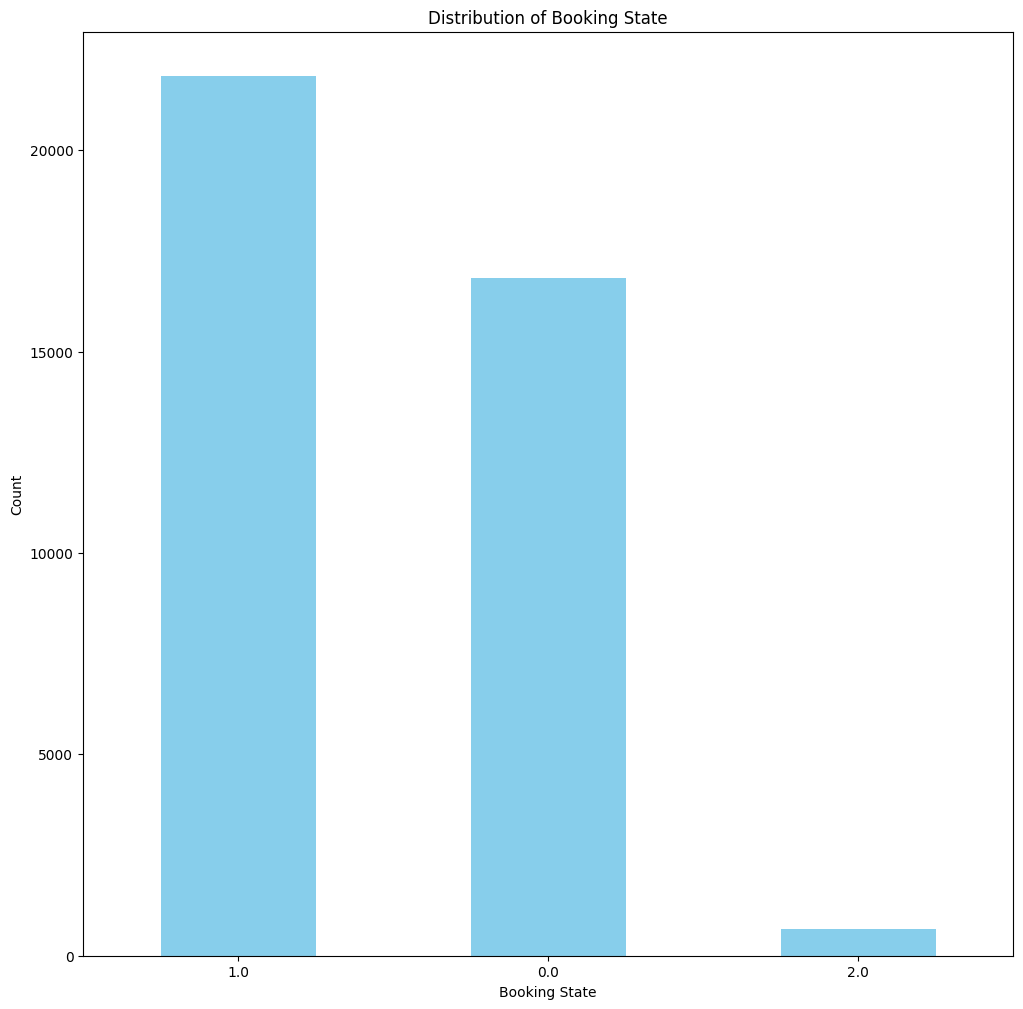

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



## Rebalancing with SMOTE

The classes are unbalanced so to make our prediction better with Random Forest despite their properties make sensitive to imbalanced dataset.

In [139]:
!pip install imbalanced-learn

In [140]:
X = canc_score_ds.drop(columns=['Status'])
y = canc_score_ds['Status']

In [141]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
canc_score_ds = pd.DataFrame(X_resampled, columns=X.columns)
canc_score_ds['Status'] = y_resampled

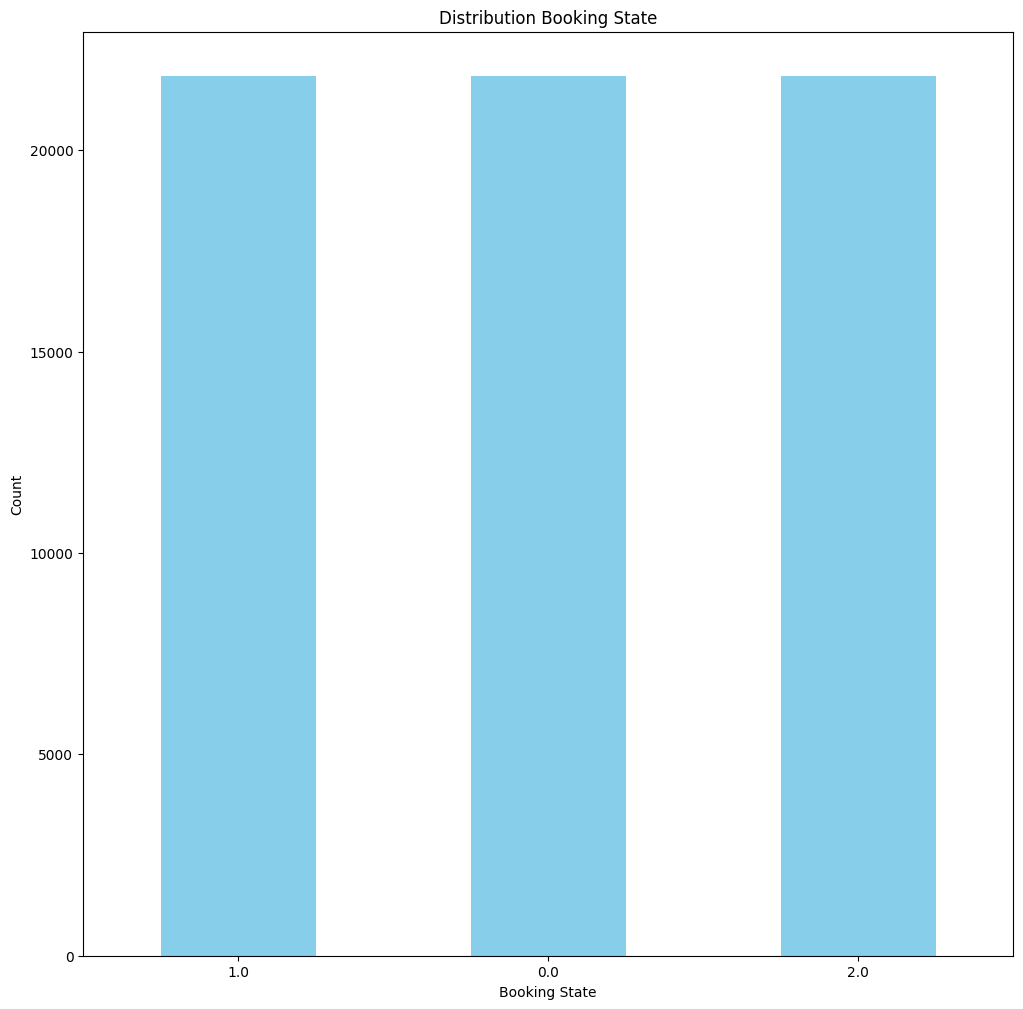

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Data augumentation worked fine, now our dataset is balanced.

### Correlation Matrix.
We want to see now how are correlated the features and how they relate.

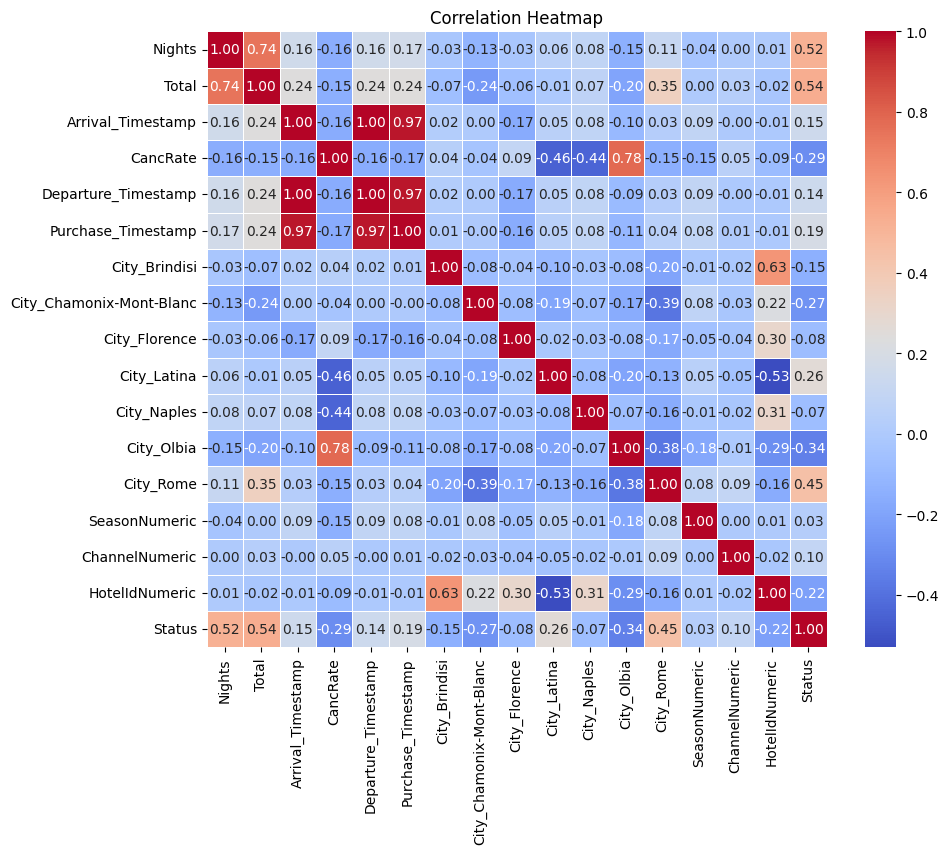

In [143]:
corr_matrix = canc_score_ds.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# Set the title for the heatmap
plt.title('Correlation Heatmap')
# Display the heatmap
plt.show()

The interesting things a weak correlation with the season and with the city and our tartget. The city and the hotel are not such important. Let see if change with balancing the dataset. Total is the total revenue and it obviously. Now we scale the training data

In [144]:
X_features = canc_score_ds.drop(columns=['Status'])
y_target = canc_score_ds['Status']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                        test_size=0.3, random_state=42)

# Principal Component Analysis
Now we prepare ourselves on PCA, later we use hyperparameters tuning and random forest to pack together with cross validation., creating a pipeline that will allow to instrumentally fit better.

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_features.shape

(65553, 16)

We want to reduce the dimensionality of the dataset but in appropriate way choosing the appropriate number of dimesion to up a given expected_variance_ratio for each princial component,let's say 95 per cent. So we split the data set, doing the fit and get the appropriate dimensions. Actually we're able to obtain the same result that we obtained with Univariate feature selection: we're able to have 11 features from 15.

In [146]:
sca = StandardScaler()
X_train = sca.fit_transform(X_train)
X_test = sca.fit_transform(X_test)

In [147]:
# project the model on two dimension in order to be able to visualize it.
# split the training set in two
from sklearn.decomposition import PCA
n_cols = X_train.shape[1]
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
# comutalive sum of the variance ration of each component
print("Dimensionality reduce from {} to {}".format(n_cols,pca.n_components_))

Dimensionality reduce from 16 to 10


We try to plot dimensionally the columns

## Cancellation Score Model: Random Forest

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
base_line_model_clf = RandomForestClassifier(n_estimators=20, random_state=42)
base_line_model_clf.fit(X_reduced, y_train)



RandomForestClassifier(n_estimators=20, random_state=42)

In [149]:
cross_val_score(base_line_model_clf, X_reduced, y_train, cv=3, scoring="accuracy")

array([0.95011768, 0.94802563, 0.95004904])

The accuracy is pretty much good. Let's do hyperparameter tuning and classification in a pipeline. Then we will add crossvalidation to same pipeline, later first we want to see results.

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
clf

Pipeline(steps=[('pca', PCA(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [151]:
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=5, cv=3, random_state=42)
tuned_clf = rnd_search.fit(X_train, y_train)

In [152]:
print ("Paramters found: {}".format(rnd_search.best_params_))

Paramters found: {'randomforestclassifier__n_estimators': 64, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini', 'pca__n_components': 14}


Notice the sensitive variations on dimensions for PCA. The next step is to create a pipeline that it is able to cross-validate itself with PCA
and RandomForest.

In [153]:
y_pred = tuned_clf.predict(X_test)

In [185]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(y_test, y_pred, output_dict=True)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9305400183057053


In [191]:
report_df = pd.DataFrame(report).transpose())
report_df

precision    recall  f1-score      support
0.0            0.999847  1.000000  0.999924   6544.00000
1.0            0.959541  0.826888  0.888289   6568.00000
2.0            0.847742  0.965060  0.902604   6554.00000
accuracy       0.930540  0.930540  0.930540      0.93054
macro avg      0.935710  0.930649  0.930272  19666.00000
weighted avg   0.935694  0.930540  0.930207  19666.00000

rossvalidation here eliminate overfitting. The accuracuy is still good enough.

In [155]:
cross_val_score(tuned_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91756015, 0.91272228, 0.91853547])

## Confusion Matrix

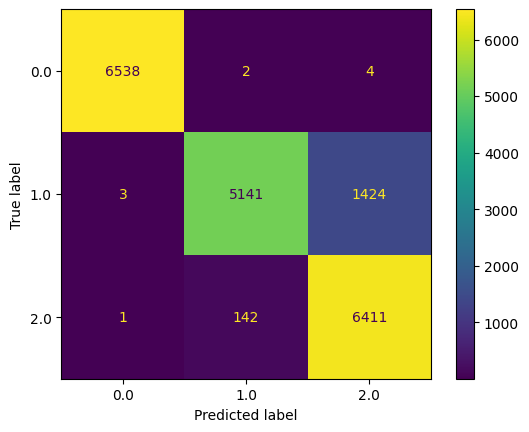

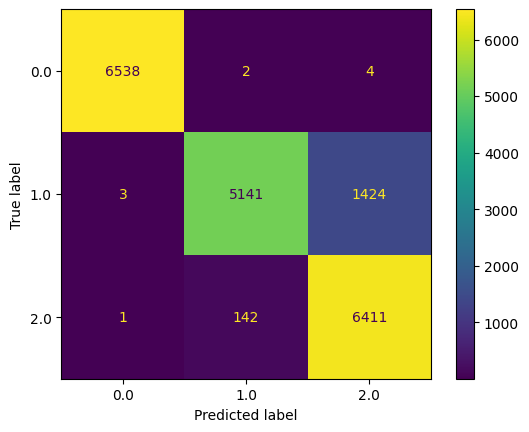

In [156]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# Then just plot it:
disp.plot()
# And show it:
plt.show()

Just 90 per cent of matches. Let's crossvalidate to avoid overfitting Stratified KFold cross validation as parameter to the pipeline. Stratified crossvalidation mantains the class distribution during the splitting and reduce overfitting. The interesting part of this graphs is that the forecasting error of caclellation is good.


In [157]:
from sklearn.model_selection import StratifiedKFold
# For classificatoion problems like this mantains the original distribution
skf = StratifiedKFold(n_splits=5)
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
# we prefer RanndomizedSarchCV becasue G
# 3 iterations should be enough
rnd_search = RandomizedSearchCV(clf, param_distrib, cv=skf, random_state=42,verbose=3)
tuned_clf_v2 = rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.779 total time=   5.8s
[CV 2/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.770 total time=   7.3s
[CV 3/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.762 total time=   5.6s
[CV 4/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.782 total time=   7.2s
[CV 5/5] END pca__n

Let see now the numbers:

In [158]:
y_pred = tuned_clf_v2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9198616902267873
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6544
         1.0       0.97      0.78      0.87      6568
         2.0       0.82      0.98      0.89      6554

    accuracy                           0.92     19666
   macro avg       0.93      0.92      0.92     19666
weighted avg       0.93      0.92      0.92     19666



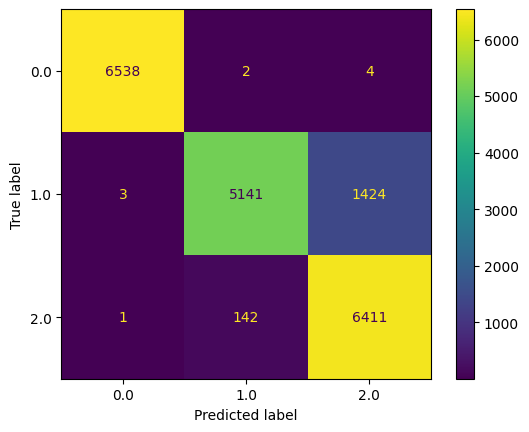

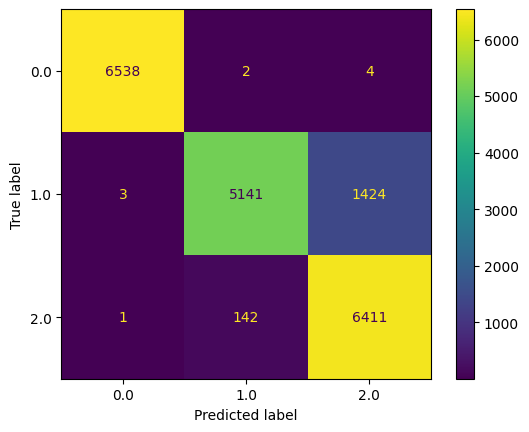

In [159]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# Then just plot it:
disp.plot()
# And show it:
plt.show()

### Singular Vector Machine: Cancellation Score.
It is interesting to see if a cross validated SVM perform better.

In [160]:
from sklearn.svm import SVC
svm_pipeline = make_pipeline(PCA(random_state=42), SVC(kernel='linear'))
cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
cv_scores

array([0.86947047, 0.8699063 , 0.86640514, 0.87457775, 0.8730522 ])

In [161]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              "pca__n_components": np.arange(2, 15),
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['rbf']}
# Set up the GridSearchCV object
grid_search = RandomizedSearchCV(svm_pipeline, param_grid, cv=skf,n_iter=3,verbose=5)
tuned_svm_model = grid_search.fit(X_train, y_train)
y_pred = tuned_svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END pca__n_components=10, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.924 total time= 1.0min
[CV 2/5] END pca__n_components=10, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.925 total time=  59.0s
[CV 3/5] END pca__n_components=10, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.923 total time= 1.0min
[CV 4/5] END pca__n_components=10, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.928 total time= 1.0min
[CV 5/5] END pca__n_components=10, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.926 total time=  59.9s
[CV 1/5] END pca__n_components=6, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.907 total time= 1.0min
[CV 2/5] END pca__n_components=6, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.910 total time=  55.8s
[CV 3/5] END pca__n_components=6, svc__C=1000, svc__gamma=0.1, svc__kernel=rbf;, score=0.905 total time=  53.4s
[CV 4/5] END pca__n_components=6, svc__

In [162]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Random Forest', 'Accuracy Cross Validated Random Forest','Accuracy CrossValidated SVC']),
                 cells=dict(values=[[0.95], [0.92],[0.94]]))])
fig.show()

# Compute Cancellation Score.
As you can see in the table the SVC model that we trained performs better, we prefer in term of deployability and performance (time to train) to use Random Forest and the model that we've trained. How we compute the cancellation score. The process is do prediction on test data and count the number of cancellations. For easy to proceed we use our test_data that we've splitted, ideally should be most recent data che comes from the user, rescaled and cleaned, where the feature HotelId is crafted explicit. Let's try to create function **compute_canc_score** that compute the cancellation score for each customers and store in a JSON file


In [163]:
!pip install iplantuml

In [164]:
import json
def compute_canc_score():
    sca = StandardScaler()
    score_dict = {}
    for k in range(0,10):
        canc_score_per_hotel = canc_score_ds[(canc_score_ds['HotelIdNumeric'] == k)].copy()
        y = canc_score_per_hotel['Status']
        X = canc_score_per_hotel.drop(['Status'],axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.5)
        X_train = sca.fit_transform(X_train)
        X_test = sca.fit_transform(X_test)
        y_pred = tuned_svm_model.predict(X_test)
        total = y_pred.shape[0]
        num_zeros = np.count_nonzero(y_pred)
        num_id = f'00{k}' if k < 10 else f'0{k}'
        hb_ds_per_hotel = canc_score_compute[(canc_score_compute['HotelId'] == num_id)].copy()
        hotel_bookings = hb_ds_per_hotel['Status'].count()
        past_cancellations = hb_ds_per_hotel[(hb_ds_per_hotel['Status']==0)]['Status'].count()
        past_score = past_cancellations / hotel_bookings if hotel_bookings > 0 else 0
        score = (total - num_zeros)/total * past_score
        print(f'HotelNumericId: {k} Reservations {hotel_bookings} Cancellations {past_cancellations} Cancellation Score: {score}')
        score_dict[num_id] = score
    return score_dict
score_dict = compute_canc_score()
with open('cancellation_score.json','w') as sc:
    json.dump(score_dict,sc)

HotelNumericId: 0 Reservations 0 Cancellations 0 Cancellation Score: 0.0
HotelNumericId: 1 Reservations 32 Cancellations 11 Cancellation Score: 0.032696015424164525
HotelNumericId: 2 Reservations 1895 Cancellations 454 Cancellation Score: 0.05510600642407114
HotelNumericId: 3 Reservations 584 Cancellations 335 Cancellation Score: 0.2619799133379417
HotelNumericId: 4 Reservations 1222 Cancellations 474 Cancellation Score: 0.06936362761143738
HotelNumericId: 5 Reservations 20 Cancellations 1 Cancellation Score: 0.01528046421663443
HotelNumericId: 6 Reservations 2776 Cancellations 1187 Cancellation Score: 0.11887975116301507
HotelNumericId: 7 Reservations 4027 Cancellations 1316 Cancellation Score: 0.03382962107225503
HotelNumericId: 8 Reservations 8816 Cancellations 4817 Cancellation Score: 0.054639292196007265
HotelNumericId: 9 Reservations 9248 Cancellations 3813 Cancellation Score: 0.12126628332994097


We've found a way to compute easily using Machine Learning and historical data score per cancellation, a score that will allow revenue managers to classify Hotel performance.

# <b>Review Score</b> using BERT Sentiment Analysis over Tripadvisor Reviews.

<p>Hotel performance in terms of revenue depends stricly from online reputation (cit), so our goal in designing <b>HotelRank</p> algorithm is to analyze reviews about our customers hotel and provide an unique score to put a linear factor in HotelRank. We can name that score as <i>review score</i>.</p>
<p><B>ReviewScore = Hotel_Rating - (0.5 * #number_negative review) + (0.25 * number of positive review)</B></p>
<p>Here we emphasize the idea that is better not having negitive than positive reviews. To compute this formula we need we are in need to perform sentiment analysis over hotel reviews.</p><p>In case the <b>ReviewScore</b> is negative we assume that his weight to HotelRank is 0</p>


State-of-the-art sentiment analysis is achieved by fine-tuning pretrained BERT models on sentiment datasets. This involves additional training of the model for a few epochs with a low learning rate. We collected reviews using a scraper coded in Go. Please condider running this part on GPU based environment. It has been runned in a game laptop with Nvida GeForce RTX.

In [165]:
!pip install tensorflow
!pip install tf-keras
!pip install transformers
!pip install datasets

The first thing that we need is to download all reviews using our Tripadvisor scraper. For having good reviews we've devoloped a scraper in Go Programming Language targeted to fetch the reviews and creating a csv file. Our objective is using pretrained BERT, fit it with Internet Movied Database data and do sentiment analysis over our review. Reviews score will be computed as weighted combination of the reviews, giving more weight to negative review.

In [166]:
import glob
import os
import os.path
import pandas as pd
DATA = os.getcwd()
print(DATA)
review_files = ''
if not is_colab:
  review_path = './reviewscore/'
else:
  review_path = '/content/drive/MyDrive/reviewscore/'

review_files = glob.glob(review_path+'*.csv')
review_dict = {}
for review in review_files:
    base_file = os.path.basename(review)
    code ='0'+base_file.split('_')[1].split('.')[0]
    review_dict[code] = os.path.join(review_path,base_file)
print(review_dict)


/content
{'017': '/content/drive/MyDrive/reviewscore/review_17.csv', '015': '/content/drive/MyDrive/reviewscore/review_15.csv', '002': '/content/drive/MyDrive/reviewscore/review_02.csv', '012': '/content/drive/MyDrive/reviewscore/review_12.csv', '005': '/content/drive/MyDrive/reviewscore/review_05.csv', '007': '/content/drive/MyDrive/reviewscore/review_07.csv', '008': '/content/drive/MyDrive/reviewscore/review_08.csv', '013': '/content/drive/MyDrive/reviewscore/review_13.csv', '009': '/content/drive/MyDrive/reviewscore/review_09.csv', '016': '/content/drive/MyDrive/reviewscore/review_16.csv', '006': '/content/drive/MyDrive/reviewscore/review_06.csv', '004': '/content/drive/MyDrive/reviewscore/review_04.csv', '018': '/content/drive/MyDrive/reviewscore/review_18.csv', '014': '/content/drive/MyDrive/reviewscore/review_14.csv', '001': '/content/drive/MyDrive/reviewscore/review_01.csv', '010': '/content/drive/MyDrive/reviewscore/review_10.csv'}


In [167]:
hotel_08 =  pd.read_csv(review_dict['008'])

In [168]:
hotel_08.head()

Location Name                                           Title  \
0              8                                 What a let down   
1              8  Superb experience, like home away from home...   
2              8                                5 stars service    
3              8                     2 ** hotel  at the upmost !   
4              8        Amazing hotel with excellent hospitality   

                                                Text  Rating  Year  Month  Day  
0  Staff very friendly and helpful.We had a suite...       3  2024      9   18  
1  We came for a weeklong stay to celebrate my wi...       5  2022      6    7  
2  So happy about this Hotel. Very good location,...       5  2022      6    4  
3  I cant believe this place has a 4 stars rating...       1  2021      6   23  
4  I had an amazing experience at the hotel. \nPe...       5  2021      6   19

In [169]:
hotel_08.isnull().sum()

Location Name    0
Title            0
Text             0
Rating           0
Year             0
Month            0
Day              0
dtype: int64

In [170]:
hotel_08.describe()

Location Name      Rating         Year       Month         Day
count          115.0  115.000000   115.000000  115.000000  115.000000
mean             8.0    4.182609  2017.200000    7.460870   15.904348
std              0.0    1.112785     3.220548    1.452686    9.598953
min              8.0    1.000000  2010.000000    3.000000    1.000000
25%              8.0    4.000000  2015.000000    6.500000    7.000000
50%              8.0    5.000000  2017.000000    8.000000   15.000000
75%              8.0    5.000000  2019.000000    9.000000   24.500000
max              8.0    5.000000  2024.000000   10.000000   31.000000

In [171]:
import plotly.express as px
grouped_data = hotel_08.groupby(['Year', 'Rating']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Year", y="Count", color="Rating", width=800, height=600,
             labels={"Review Year": "Customer Arrival Timestamp", "Count": "Number Review", "Rating": "Rating"},
             title="Distribution of TripAdvisor Review Rating per Year")
fig.show()

Blasteness most important customer performed quite well in terms of online reputation. Most of the review rating are yellow.
The review score should also follow this trend to be accurate.
At this point we're in need of doing sentiment analysis about the reviews and we've found the the state of art of sentiment analysis is Google Bert (https://research.google/pubs/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/). Here we've tried two options:
1.  using a hugginface pretrained model and tokenizer and fit against IMDB dataset using Tensorflow and Keras but takes on Google Colab, more the 1 day
2. Use an already fitted model with SparkNLP. It is fast and easy preductionble.

After struggling a bit we've opted for the second option.

## Sentiment Analysis with SparkNLP

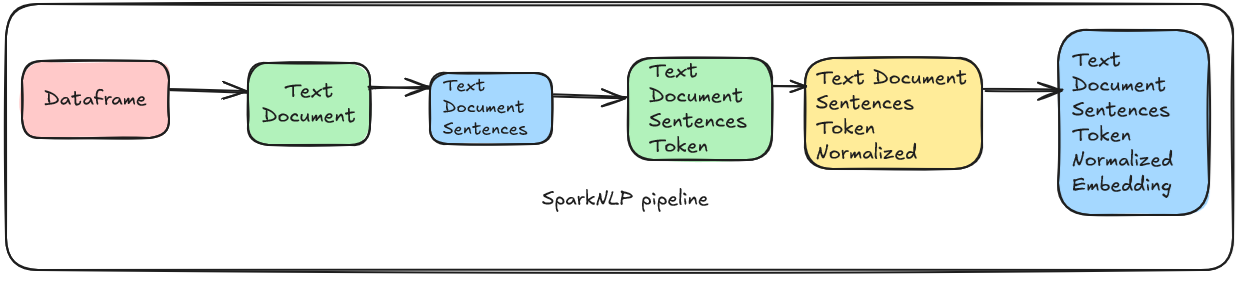

Spark NLP is a natural language processing library written on top of SparkML library and allow us to use Spark and Pretrained language models.
Use the concept of pipeline to perform his duties, above we see a typical pipeline from a dataframe we've embeddings. In our case we'll use just a subset of stages:

1.   Create a TextDocument thru **DocumentAssemblerClass**.
2.   Load a pretrained and fitted against IMDB, BERT model.
3.   Load a pretrainer tokenizer
4.   Tokenize the document.
5.   Embedding and Classify sentences.



In [172]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.4

In [173]:
from sparknlp.base import *
from sparknlp.annotator import Tokenizer, BertForSequenceClassification
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

spark = sparknlp.start()

In [174]:
df = spark.read.format("csv").option("header",True).load("/content/drive/MyDrive/reviewscore/review_08.csv")
df.count()

289

In [175]:
df = df.filter(df.Text.isNotNull())
df.count()

186

In [176]:
document_assembler = DocumentAssembler() \
        .setInputCol('Text') \
        .setOutputCol('document')
tokenizer = Tokenizer() \
        .setInputCols(['document']) \
        .setOutputCol('token')
bert_cls = BertForSequenceClassification.pretrained("bert_classifier_fabriceyhc_base_uncased_imdb", "en") \
        .setInputCols(['document', 'token']) \
        .setOutputCol('class')

pipeline = Pipeline(stages=[document_assembler,
                            tokenizer,
                            bert_cls])

bert_classifier_fabriceyhc_base_uncased_imdb download started this may take some time.
Approximate size to download 390.9 MB
[OK!]


In [177]:
result = pipeline.fit(df).transform(df)

In [178]:

result.show()
#review_score = rating + 0.5 * negative + 0.25 * (positive/count)
#print('Review score for hotel 008: {score}')


+--------------------+--------------------+--------------------+------+----+-----+----+--------------------+--------------------+--------------------+
|       Location Name|               Title|                Text|Rating|Year|Month| Day|            document|               token|               class|
+--------------------+--------------------+--------------------+------+----+-----+----+--------------------+--------------------+--------------------+
|                  08|     What a let down|Staff very friend...|  null|null| null|null|[{document, 0, 73...|[{token, 0, 4, St...|[{category, 0, 73...|
|Looks like the Ho...|                   3|                2024|    09|  18| null|null|[{document, 0, 3,...|[{token, 0, 3, 20...|[{category, 0, 3,...|
|                  08|Superb experience...|We came for a wee...|  null|null| null|null|[{document, 0, 36...|[{token, 0, 1, We...|[{category, 0, 36...|
|Improvement oppor...|                   5|                2022|    06|  07| null|null|[{docum

Now we can generalize the process creating a functions and object called ReviewScoreBuilder

In [179]:
"""
class ReviewScoreBuilder:
  def __init__(self, review_dict: dict) -> None:
    self._review_dict = review_dict
    self._data_map = {}
    self._pipeline = self._create_pipeline()
  def load_data(self):
    for code, path in self._review_dict.items():
      df = spark.read.format("csv").option("header",True).load(value)
      df = df.filter(df.Text.isNotNull())
      self._data_map['code']
  def _create_pipeline(self):
      document_assembler = DocumentAssembler() \
        .setInputCol('Text') \
        .setOutputCol('document')
      tokenizer = Tokenizer() \
        .setInputCols(['document']) \
        .setOutputCol('token')
      bert_cls = BertForSequenceClassification.pretrained("bert_classifier_fabriceyhc_base_uncased_imdb", "en") \
        .setInputCols(['document', 'token']) \
        .setOutputCol('class')

      self._pipeline = Pipeline(stages=[document_assembler,
                            tokenizer,
                            bert_cls])
  def computeScores(self):
    scores = dict()
    for code, dataframe in self._data_map.items():
      result = self.pipeline.fit(dataframe).transform(dataframe)
      scores[code] = dataframe
    return scores

"""

'\nclass ReviewScoreBuilder:\n  def __init__(self, review_dict: dict) -> None:\n    self._review_dict = review_dict\n    self._data_map = {}\n    self._pipeline = self._create_pipeline()\n  def load_data(self):\n    for code, path in self._review_dict.items():\n      df = spark.read.format("csv").option("header",True).load(value)\n      df = df.filter(df.Text.isNotNull())\n      self._data_map[\'code\']\n  def _create_pipeline(self):\n      document_assembler = DocumentAssembler()         .setInputCol(\'Text\')         .setOutputCol(\'document\')\n      tokenizer = Tokenizer()         .setInputCols([\'document\'])         .setOutputCol(\'token\')\n      bert_cls = BertForSequenceClassification.pretrained("bert_classifier_fabriceyhc_base_uncased_imdb", "en")         .setInputCols([\'document\', \'token\'])         .setOutputCol(\'class\')\n                \n      self._pipeline = Pipeline(stages=[document_assembler,\n                            tokenizer,\n                            be

## Conclusion.
The result of this work provided a method, HotelRank, to use for RMS developer to compare different hotels and understand his performance using machine learning
and deep learning methods. The productization is an ongoing effort, outside the scope of this project.